# EDA(Exploratory Data Analysis)

## 0. 목차

- [1. 분석 환경 구축](#1.-분석환경-구축)
    - [1.1 패키지 불러오기](#1.1-패키지-불러오기)
    - [1.2 데이터 불러오기](#1.2-데이터-불러오기)
- [2. 변수 뜯어보기](#2.-변수-뜯어보기)
    - [2.1 Train set](#2.1-Train-data-set)
    - [2.2 Validation set](#2.2-Validation-data-set)
    - [2.3 Test set](#2.3-Test-data-set)
    - [2.4 곡 장르 코드 데이터](#2.4-곡-장르-코드-데이터)
    - [2.5 곡 메타 데이터](#2.5-곡-메타-데이터)
- [3. 데이터 시각화](#3.-데이터-시각화)
- [4. ]()
- [5. ]()

나의 목표

1. Inductive한 모델을 만드는 것
  - Transductive한 모델은 결국 새로운 데이터를 예측할 때마다 모델을 학습시켜야하기 때문에 효용성이 떨어진다.
2. heterogeneous feature를 함께 학습시키는 모델을 만드는 것
  - User와 item의 임베딩 및 관계뿐만 아니라 메타데이터들도 함께 학습하며 필요하다면 계층적인 모델을 구축한다.
3.
4.
5.

## 1. 분석 환경 구축

### 1.1 패키지 불러오기

In [ ]:
# 구글드라이브에서 colab으로 디렉토리 환경 편입
import os, sys
from google.colab import drive
drive.mount('/content/drive')

my_path = '/content/notebooks'
try: os.symlink('/content/drive/My Drive/Colab Notebooks/my_env', my_path)
except: print('\nAlready linked...')
sys.path.insert(0, my_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Already linked...


In [ ]:
# matplotlib 한글폰트 적용
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from pandas.plotting import register_matplotlib_converters

%config InlineBackend.figure_format = 'retina'
!apt -qq -y install fonts-nanum > /dev/null

font_path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font_name = fm.FontProperties(fname = font_path, size = 10).get_name()
fm._rebuild()

plt.rc('font', family = font_name, size = 12)
plt.rcParams["figure.figsize"] = (15, 8)
plt.rcParams['axes.unicode_minus'] = False

# colab 환경에서는 한글폰트 적용을 위해 런타임 재시작 필요

In [ ]:
import re, glob, gc, io, copy, warnings
import distutils.dir_util
import json
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None

from tqdm.notebook import tqdm

from collections import Counter
from itertools import chain
from datetime import timedelta, datetime

import seaborn as sns
from plotnine import *

warnings.filterwarnings(action='ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### 1.2 데이터 불러오기

In [ ]:
display(glob.glob('drive/My Drive/kakao_arena/data/*'))
base_path = 'drive/My Drive/kakao_arena/'

['drive/My Drive/kakao_arena/data/val.json',
 'drive/My Drive/kakao_arena/data/test.json',
 'drive/My Drive/kakao_arena/data/genre_gn_all.json',
 'drive/My Drive/kakao_arena/data/train.json',
 'drive/My Drive/kakao_arena/data/song_meta.json',
 'drive/My Drive/kakao_arena/data/train_up.json',
 'drive/My Drive/kakao_arena/data/song_meta_clean.json',
 'drive/My Drive/kakao_arena/data/tag_archive.json',
 'drive/My Drive/kakao_arena/data/plylst_titles.txt']

In [ ]:
train = pd.read_json(base_path + 'data/train.json')
masked_train = pd.read_json(base_path + 'validation/masked_train.json')

print(train.shape)
train.head(3)

(115071, 6)


,tags,id,plylst_title,songs,like_cnt,updt_date
0,[락],61281,여행같은 음악,"[525514, 129701, 383374, 562083, 297861, 13954...",71,2013-12-19 18:36:19.000
1,"[추억, 회상]",10532,요즘 너 말야,"[432406, 675945, 497066, 120377, 389529, 24427...",1,2014-12-02 16:19:42.000
2,"[까페, 잔잔한]",76951,"편하게, 잔잔하게 들을 수 있는 곡.-","[83116, 276692, 166267, 186301, 354465, 256598...",17,2017-08-28 07:09:34.000


In [ ]:
valid = pd.read_json(base_path + 'data/val.json')

print(valid.shape)
valid.head(3)

(23015, 6)


,tags,id,plylst_title,songs,like_cnt,updt_date
0,[],118598,,"[373313, 151080, 275346, 696876, 165237, 52593...",1675,2019-05-27 14:14:33.000
1,[],131447,앨리스테이블,[],1,2014-07-16 15:24:24.000
2,[],51464,,"[529437, 516103, 360067, 705713, 226062, 37089...",62,2008-06-21 23:26:22.000


In [ ]:
test = pd.read_json(base_path + 'data/test.json')

print(test.shape)
test.head(3)

(10740, 6)


,tags,id,plylst_title,songs,like_cnt,updt_date
0,[],70107,,"[398985, 449403, 411543, 528044, 143048, 98020...",6,2012-09-29 01:57:26.000
1,"[나만의Best3, 인디아티스트들의추천음악]",7461,,"[196298, 269984, 267805, 175867, 529244, 63825...",0,2019-12-17 14:06:45.000
2,[드라이브],90348,,"[273433, 331003, 68432, 411659, 117793, 616860...",21,2015-05-23 10:44:48.000


In [ ]:
# DB genre code table
genre = pd.read_json(base_path + 'data/genre_gn_all.json', typ = 'series')
genre = pd.DataFrame(genre, columns = ['gnr_name']).reset_index().rename(columns = {'index' : 'gnr_code'})

print(genre.shape)
#pd.set_option('display.max_rows', 10)
genre.head(3)

(254, 2)


,gnr_code,gnr_name
0,GN0100,발라드
1,GN0101,세부장르전체
2,GN0102,'80


In [ ]:
%%time
song_meta = pd.read_json(base_path + 'data/song_meta.json', typ = 'frame')

print(song_meta.shape)
display(song_meta.head(3))

(707989, 9)


,song_gn_dtl_gnr_basket,issue_date,album_name,album_id,artist_id_basket,song_name,song_gn_gnr_basket,artist_name_basket,id
0,[GN0901],20140512,불후의 명곡 - 7080 추억의 얄개시대 팝송베스트,2255639,[2727],Feelings,[GN0900],[Various Artists],0
1,"[GN1601, GN1606]",20080421,"Bach : Partitas Nos. 2, 3 & 4",376431,[29966],"Bach : Partita No. 4 In D Major, BWV 828 - II....",[GN1600],[Murray Perahia],1
2,[GN0901],20180518,Hit,4698747,[3361],Solsbury Hill (Remastered 2002),[GN0900],[Peter Gabriel],2


CPU times: user 16.6 s, sys: 1.4 s, total: 18 s
Wall time: 18.2 s


## 2. 데이터 시각화

### 2.1 데이터 분포

주어진 train, valid, test 데이터 셋들은 원래 하나의 데이터에서 split_data.py 모듈을 통해 나누어진 것으로 추측됩니다.

In [ ]:
# mask된 train data까지 모두를 병합해줍니다.
df = pd.concat([train.assign(group = 'train'), 
                masked_train.assign(group = 'masked_train'),
                valid.assign(group = 'valid'), 
                test.assign(group = 'test')], axis = 0)
df.head(3)

,tags,id,plylst_title,songs,like_cnt,updt_date,group
0,[락],61281,여행같은 음악,"[525514, 129701, 383374, 562083, 297861, 13954...",71,2013-12-19 18:36:19.000,train
1,"[추억, 회상]",10532,요즘 너 말야,"[432406, 675945, 497066, 120377, 389529, 24427...",1,2014-12-02 16:19:42.000,train
2,"[까페, 잔잔한]",76951,"편하게, 잔잔하게 들을 수 있는 곡.-","[83116, 276692, 166267, 186301, 354465, 256598...",17,2017-08-28 07:09:34.000,train


In [ ]:
df = df.assign(
    tag_cnt = lambda x: x.tags.apply(len),
    song_cnt = lambda x: x.songs.apply(len),
    group = lambda x: x.group.astype('category').cat.set_categories(['train', 'masked_train', 'valid', 'test']),
    title_null_yn = lambda x: x.plylst_title.apply(lambda x: True if x == '' else False)
).sort_values('id')
df.head(3)

,tags,id,plylst_title,songs,like_cnt,updt_date,group,tag_cnt,song_cnt,title_null_yn
35528,[힙합],1,*________* 질리지 않는 이 곡 들!,"[308020, 117747]",2,2011-11-22 17:31:01.000,masked_train,1,2,False
77015,"[힙합, 랩]",1,*________* 질리지 않는 이 곡 들!,"[47805, 308020, 662131, 418970, 117747]",2,2011-11-22 17:31:01.000,train,2,5,False
108461,"[밤, 새벽]",2,좋은 꿈을 꿀것같은 사랑스러운 음악,"[424482, 618641, 642016, 115311, 12130, 577345...",11,2014-07-28 12:30:32.000,train,2,16,False


In [ ]:
# like_cnt, tag_cnt, song_cnt 분포를 확인합니다.
df.melt(id_vars = 'group', value_vars = ['like_cnt', 'tag_cnt', 'song_cnt'], value_name = 'statistics')\
  .groupby(['variable', 'group']).describe(percentiles = [0.5, 0.75, 0.95])

statistics                         ...                      
                           count       mean         std  ...   75%    95%      max
variable group                                           ...                      
like_cnt train          115071.0  95.197687  560.653757  ...  24.0  399.0  53211.0
         masked_train   115071.0  95.197687  560.653757  ...  24.0  399.0  53211.0
         valid           23015.0  89.096937  511.797842  ...  24.0  383.3  32695.0
         test            10740.0  91.139106  601.143498  ...  24.0  395.1  36075.0
song_cnt train          115071.0  45.935735   43.950335  ...  54.0  156.0    200.0
         masked_train   115071.0  18.146362   21.635858  ...  22.0   67.0    100.0
         valid           23015.0  18.301065   21.544313  ...  23.0   67.0    100.0
         test            10740.0  18.402980   21.649619  ...  23.0   67.0    100.0
tag_cnt  train          115071.0   4.139453    3.072261  ...   6.0   10.0     11.0
         masked_train   115071.0   1.178081    1.577528  ...   2.0    5.0      5.0
         valid           23015.0   1.187834    1.575660  ...   2.0    5.0      5.0
         test            10740.0   1.185940    1.567718  ...   2.0    5.0      5.0

[12 rows x 8 columns]

In [ ]:
# 플레이리스트 제목의 결측 비율을 확인합니다.
df.groupby('group')['title_null_yn'].agg(title_missing_prop = lambda x: x.sum() / x.count())

,title_missing_prop
group,
train,0.000000
masked_train,0.000000
valid,0.809993
test,0.809963


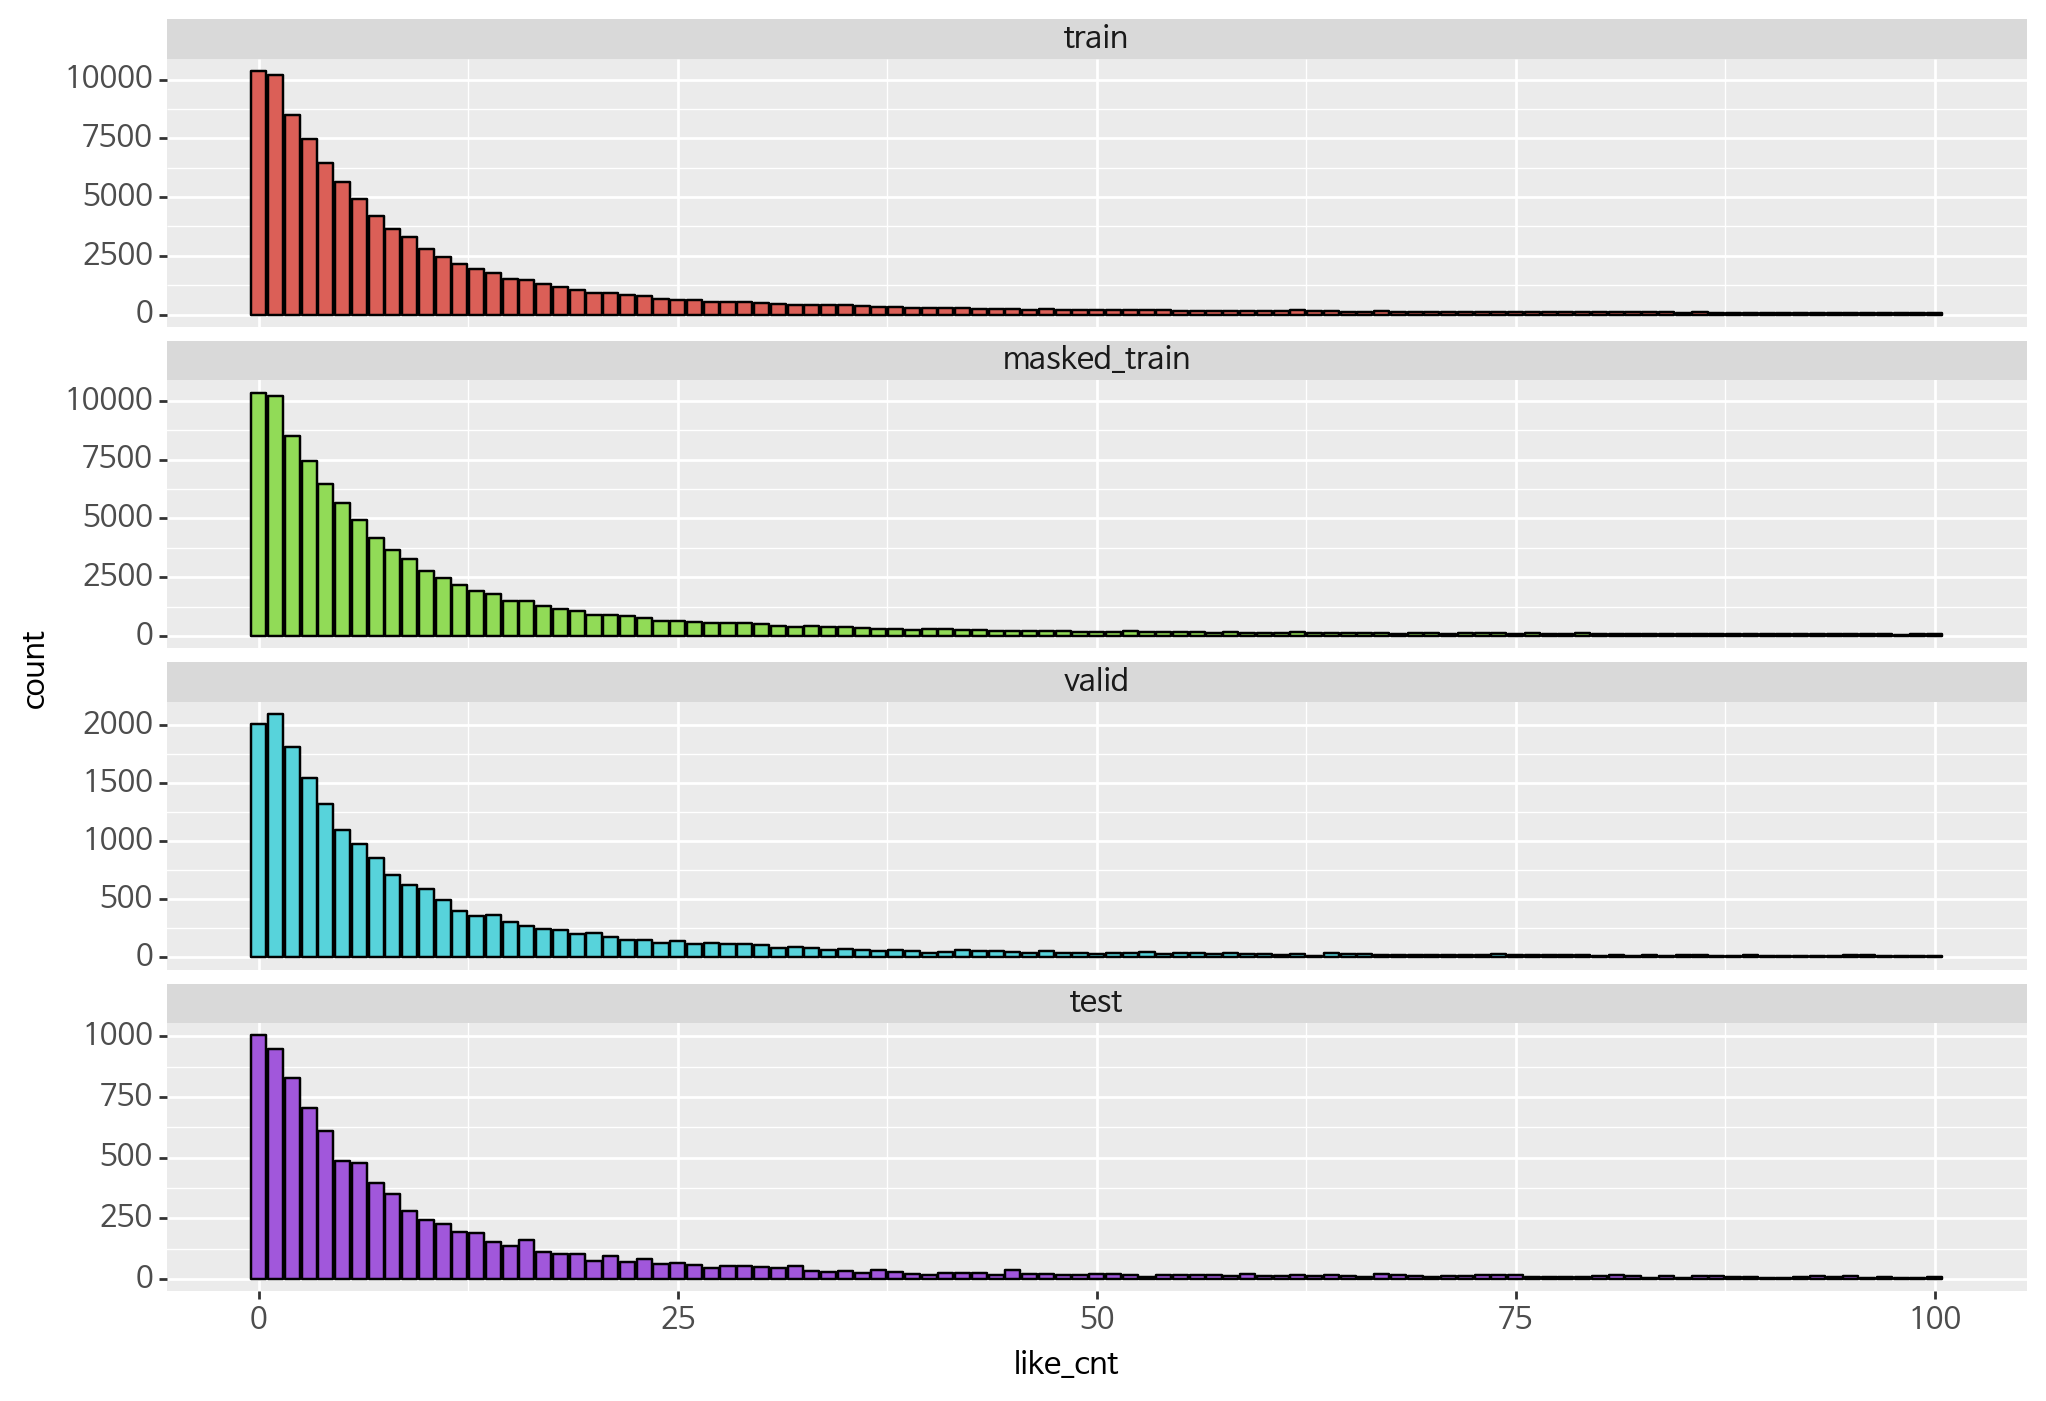

<ggplot: (8775767333745)>

In [ ]:
(ggplot(data = df.query('like_cnt <= 100')) +
 stat_count(aes(x = 'like_cnt', fill = 'group'), color = 'black', show_legend = 'F') +
 facet_wrap('group', nrow = 4, scales = 'free_y') +
 theme(text = element_text(fontproperties=font_name),
       figure_size=(12, 8))
 )

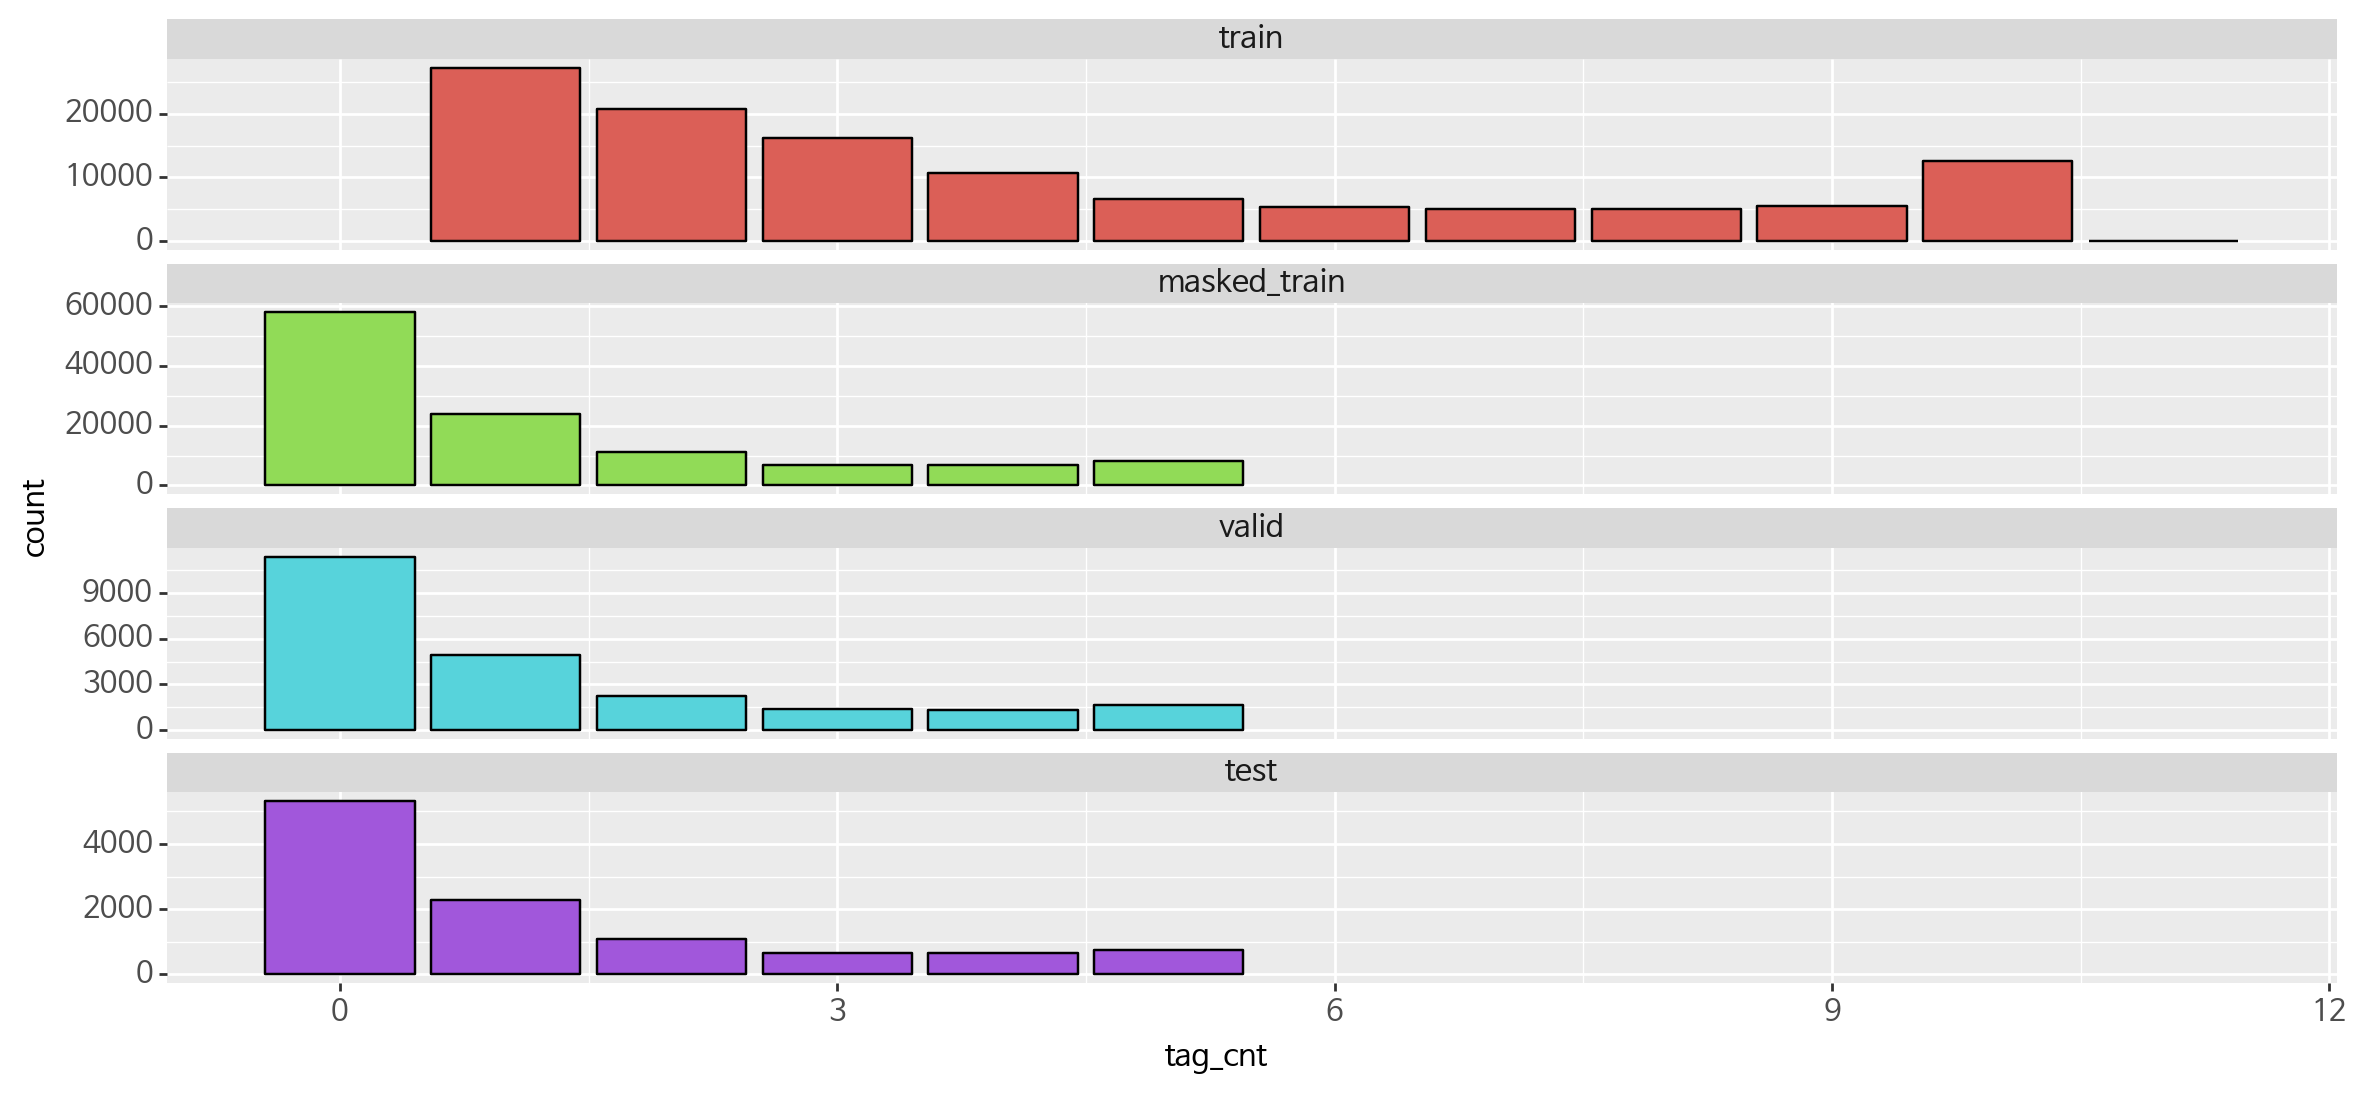

<ggplot: (8775765393058)>

In [ ]:
(ggplot(data = df) +
 stat_count(aes(x = 'tag_cnt', fill = 'group'), color = 'black', show_legend = 'F') +
 facet_wrap('group', nrow = 4, scales = 'free_y') +
 theme(text = element_text(fontproperties=font_name),
       figure_size=(14, 6))
 )

보다시피 split_data.py를 이용해 masking된 train 데이터는 valid 및 test 데이터와 거의 비슷한 분포를 가지는 것을 알 수 있습니다.

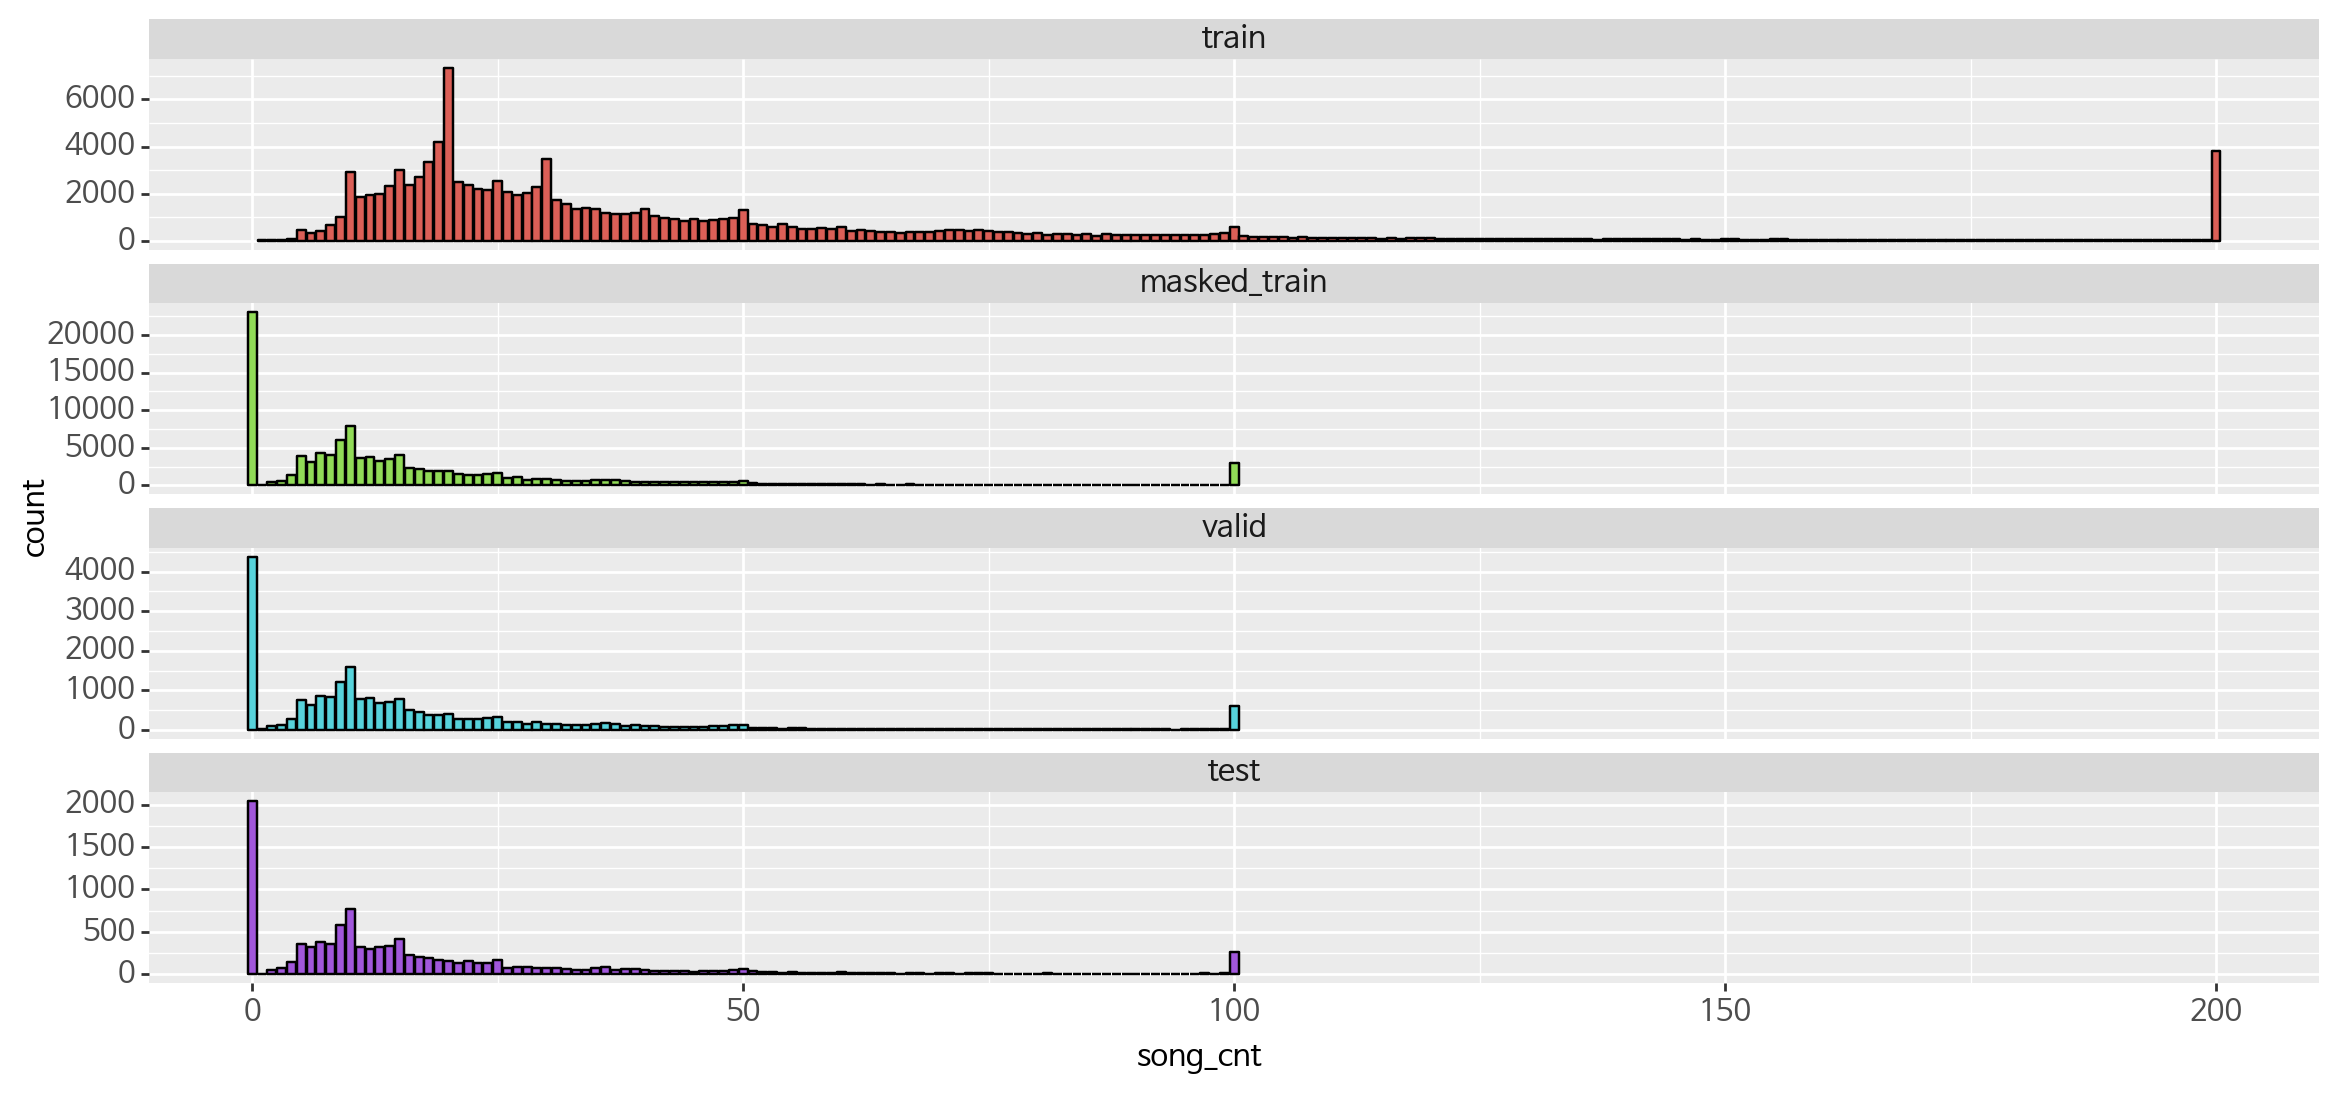

<ggplot: (-9223363261087498748)>

In [ ]:
(ggplot(data = df) +
 stat_count(aes(x = 'song_cnt', fill = 'group'), color = 'black', show_legend = 'F') +
 facet_wrap('group', nrow = 4, scales = 'free_y') +
 theme(text = element_text(fontproperties=font_name),
       figure_size=(14, 6))
 )

In [ ]:
# 플레이리스트 제목이 없고 태그도 없는 경우
df.query('title_null_yn == True & tag_cnt == 0').head(3)

,tags,id,plylst_title,songs,like_cnt,updt_date,group,tag_cnt,song_cnt,title_null_yn
6677,[],11,,"[349306, 656257, 542920, 53522, 524953, 480518...",11,2013-10-30 16:24:50.000,test,0,26,True
11188,[],23,,"[606923, 364111, 538777, 234196, 707031, 63575...",8,2014-03-21 09:59:27.000,valid,0,14,True
4739,[],32,,"[11240, 232619, 650648, 597042, 291561, 548179...",30,2010-01-08 10:32:57.000,test,0,7,True


In [ ]:
# 플레이리스트 제목이 없고 곡도 없는 경우
df.query('title_null_yn == True & song_cnt == 0').head(3)

,tags,id,plylst_title,songs,like_cnt,updt_date,group,tag_cnt,song_cnt,title_null_yn
12607,[],2996,,[],229,2018-10-08 13:16:50.000,valid,0,0,True
19221,"[봄, 연주곡, Morning, Instrumental, 아침]",15941,,[],13,2019-05-24 09:52:50.000,valid,5,0,True
22830,[],22014,,[],3,2015-05-25 17:10:52.000,valid,0,0,True


In [ ]:
# 플레이리스트 제목이 없고 이건뭐 아무것도 없는 경우
df.query('title_null_yn == True & tag_cnt == 0 & song_cnt == 0').head(3)

,tags,id,plylst_title,songs,like_cnt,updt_date,group,tag_cnt,song_cnt,title_null_yn
12607,[],2996,,[],229,2018-10-08 13:16:50.000,valid,0,0,True
22830,[],22014,,[],3,2015-05-25 17:10:52.000,valid,0,0,True
6113,[],108253,,[],28,2012-07-27 17:22:57.000,valid,0,0,True


### 2.4 태그

In [ ]:
# 태그 top 10
tag_rank = train.tags.explode().dropna().value_counts().to_frame().reset_index().rename(columns = {'index': 'tags', 'tags': 'counts'})
tag_rank.head(10)

,tags,counts
0,기분전환,16465
1,감성,11417
2,휴식,11215
3,발라드,10796
4,잔잔한,10218
5,드라이브,10095
6,힐링,9783
7,사랑,8704
8,새벽,8320
9,밤,7615


In [ ]:
# 플레이리스트에서 한 번만 등장하는 태그
tag_rank.query('counts == 1')

,tags,counts
11729,아티쇼,1
11730,스포츠대회,1
11731,존윌리암스,1
11732,BlackSabbath,1
11733,분위기POP,1
...,...,...
29155,연애감정,1
29156,차분히마음가라앉히기,1
29157,얼마나쓴거야,1
29158,마크노플러,1


In [ ]:
# 플레이리스트에서 두 번 이상 등장하는 태그
tag_rank.query('counts > 1')

,tags,counts
0,기분전환,16465
1,감성,11417
2,휴식,11215
3,발라드,10796
4,잔잔한,10218
...,...,...
11724,책방,2
11725,쎈,2
11726,한국힙합명반,2
11727,개빡치네,2


6월 둘째주 목표
- 태그로 item-item matrix를 생성하여 각 태그마다 가장 연관성 높은 태그를 추출
- 곡이 없고 태그만 있는 경우 (+플레이리스트 제목까지 없는 경우 이러한 item-based collaborative filtering을 이용하여 태그 추천할 예정

In [ ]:
plylst_dic = {e: i for i, e in enumerate(train.id)}

In [ ]:
tag_info = train.reset_index().rename(columns = {'index': 'plylst_idx'}).explode('tags').groupby('tags', as_index = False)[['plylst_idx']].agg(list)
tag_info.head(3)

,tags,plylst_idx
0,,[56921]
1,00,"[10928, 93269, 93944, 110151]"
2,007,"[72920, 85823, 91141]"


In [ ]:
import scipy.sparse as spr
from sklearn.metrics.pairwise import cosine_similarity, linear_kernel

In [ ]:
def make_item_user_matrix(tag_info = tag_info):
  row = list(tag_info.explode('plylst_idx').index)
  col = list(tag_info.explode('plylst_idx').plylst_idx)
  data = np.repeat(1, tag_info.plylst_idx.apply(len).sum())
  return spr.csr_matrix((data, (row, col)), shape = (tag_info.index.size, train.index.size))

In [ ]:
item_user_matrix = make_item_user_matrix()

In [ ]:
def top_k_recommend(item, k = 10, item_user_matrix = item_user_matrix):
  sim = linear_kernel(item, item_user_matrix).reshape(-1)
  return list(sim.argsort()[-21:-1][::-1])

In [ ]:
def tag_top_k(item_user_matrix = item_user_matrix):
  rec = []
  for item in tqdm(item_user_matrix):
    rec.append(top_k_recommend(item))
  return rec

In [ ]:
#result = list(map(top_k_recommend, item_user_matrix))

In [ ]:
result = tag_top_k

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
tfidf = TfidfVectorizer(stop_words = 'english')

In [ ]:
tfidf_matrix = tfidf.fit_transform(tag_info.tags)

print(tfidf_matrix.shape)

(29160, 28841)


In [ ]:
tag_info.query('tags == "기분전환"').index.values

array([7065])

In [ ]:
result[7065]

array([ 9839, 28675,  5234, 16916, 28902, 25059, 14621, 19089, 16481,
       22262, 11595, 18869, 13596, 26439, 15439,  2737, 24659, 20316,
        5772, 12967])

### 2.2 곡 메타데이터 날짜 전처리

- 곡 발매 일자보다 플레이리스트 업데이트 일자가 빠른 경우
- 곡 발매 일자가 0인 경우
- 플레이리스트 업데이트 일자도 확인바람

In [ ]:
%%time
plylst_date_info = pd.merge(
    df.query('group != "masked_train"').filter(items = ['id', 'songs', 'updt_date']).explode('songs'), 
    song_meta.filter(items = ['issue_date', 'id']).rename(columns = {'id': 'song_id'}), 
    how = 'left', left_on = 'songs', right_on = 'song_id'
).\
drop(columns = 'song_id').\
dropna().\
assign(
    updt_date = lambda x: pd.to_datetime(x.updt_date).dt.strftime('%Y%m%d').astype(int),
    issue_date = lambda x: x.issue_date.astype(int)
)

plylst_date_info.head(3)

,id,songs,updt_date,issue_date
0,1,47805,20111122,20100506
1,1,308020,20111122,20101109
2,1,662131,20111122,20110511


In [ ]:
# 발매일이 0 이면서 플레이리스트에 추가되어 있는 곡들 정보
plylst_date_info.query('issue_date == 0').updt_date.describe().astype(int)

count        7082
mean     20155486
std         36979
min      20041116
25%      20130805
50%      20160809
75%      20190425
max      20200423
Name: updt_date, dtype: int64

In [ ]:
anormal_date = plylst_date_info.query('updt_date < issue_date | issue_date == 0').songs.unique()
print(anormal_date.shape)
song_meta.loc[anormal_date].head(3)

(5587,)


,song_gn_dtl_gnr_basket,issue_date,album_name,album_id,artist_id_basket,song_name,song_gn_gnr_basket,artist_name_basket,id
418970,"[GN0501, GN0304, GN0505, GN0301]",20111122,세,2009906,[459383],어이세,"[GN0500, GN0300]",[fa`ce],418970
117747,"[GN0501, GN0304, GN0505, GN0301]",20111122,세,2009906,[459383],난장 된지금 (Feat. Snacky Chan),"[GN0500, GN0300]",[fa`ce],117747
53980,"[GN1012, GN1008, GN1001]",20140728,Ask Me Tomorrow,366787,[183428],Love Songs On The Radio,[GN1000],[Mojave 3],53980


In [ ]:
replace_date = pd.merge(
    song_meta.loc[anormal_date],
    plylst_date_info.drop(columns = ['issue_date', 'id']),
    how = 'left', left_on = 'id', right_on = 'songs'
).groupby('id')[['issue_date', 'updt_date']].agg('min')

In [ ]:
song_meta.loc[replace_date.index, 'issue_date'] = replace_date.updt_date

In [ ]:
for idx in tqdm(song_meta.index):
  if song_meta.at[idx, 'issue_date'] == 0:
    continue
  try:
    song_meta.at[idx, 'issue_date'] = int(pd.to_datetime(song_meta.at[idx, 'issue_date'], format = '%Y%m%d').strftime('%Y%m%d'))
  except:
    song_meta.at[idx, 'issue_date'] = song_meta.at[idx, 'issue_date'] // 10000 * 10000 + 101

In [ ]:
song_meta.query('issue_date < 19000000').issue_date.describe().astype(int)

count    326
mean     101
std        0
min      101
25%      101
50%      101
75%      101
max      101
Name: issue_date, dtype: int64

### 2.3 곡 메타데이터 장르 전처리

- song_gn_gnr_basket에서 비정상적인 코드 식별
  - 코드: GN9000
  - 특징: 
    - 다른 장르코드와 함께 있지는 않음
    - 다양한 장르의 곡에 걸쳐서 나타남
- song_gn_dtl_gnr_basket에는 문제 없음

In [ ]:
song_meta.album_name.apply()

0                              불후의 명곡 - 7080 추억의 얄개시대 팝송베스트
1                             Bach : Partitas Nos. 2, 3 & 4
2                                                       Hit
3         Feeling Right (Everything Is Nice) (Feat. Popc...
4                                                   그남자 그여자
                                ...                        
707984                 The Best Best Of The Black President
707985                                          True Colors
707986                    행보 2015 윤종신 / 작사가 윤종신 Live Part.1
707987                                   명상의 시간을 위한 뉴에이지 음악
707988                                             김경호 Live
Name: album_name, Length: 707989, dtype: object

In [ ]:
# find GN9000
anormal_genre = song_meta.explode('song_gn_gnr_basket').query('song_gn_gnr_basket == "GN9000"')
print(anormal_genre.shape)
anormal_genre.head(3)

(1834, 9)


,song_gn_dtl_gnr_basket,issue_date,album_name,album_id,artist_id_basket,song_name,song_gn_gnr_basket,artist_name_basket,id
262,[],20150318,노년의 건강을 지켜주는 음악 처방전 (부제 : 휴식 때 들으면 좋은 음악친구),2309524,[726909],Bio Sound `Breathing & Big Bell`,GN9000,[차병원],262
916,[],20170825,크리스마스의 기적,10090652,[750416],Springtime In December,GN9000,[Larry Warren],916
1074,[],20131128,Open It Up,10008901,[1221466],Open It Up,GN9000,[Tchengiz],1074


In [ ]:
# only ['GN9000']?
song_meta.loc[anormal_genre.index, 'song_gn_gnr_basket'].explode().unique()

array(['GN9000'], dtype=object)

In [ ]:
genre[genre.gnr_code.str[-2:] == '00']

,gnr_code,gnr_name
0,GN0100,발라드
6,GN0200,댄스
12,GN0300,랩/힙합
18,GN0400,R&B/Soul
22,GN0500,인디음악
32,GN0600,록/메탈
39,GN0700,성인가요
50,GN0800,포크/블루스
56,GN0900,POP
65,GN1000,록/메탈


In [ ]:
up_song_meta = pd.DataFrame()
up_song_meta[['album_name', 'song_gn_gnr_basket', 'song_name', 'artist_name_basket']] = song_meta[['album_name', 'song_gn_gnr_basket', 'song_name', 'artist_name_basket']]

In [ ]:
def update_genre(_df, _regex, _code):
  up_df = _df.copy()
  up_df.loc[anormal_genre[anormal_genre.album_name.str.contains(_regex)].index, 'song_gn_gnr_basket']\
    .apply(lambda x: x.append('GN3000') or x)
  return up_df

In [ ]:
up_song_meta = update_genre(up_song_meta, '크리스마스|Chirstmas', 'GN3000')
up_song_meta = update_genre(up_song_meta, '태교|아기|아가|어린이', 'GN2200')
up_song_meta = update_genre(up_song_meta, 'OST|중계가', 'GN1500')
up_song_meta = update_genre(up_song_meta, '건강+'', 'GN3000')
up_song_meta = update_genre(up_song_meta, '크리스마스', 'GN3000')

In [ ]:
anormal_genre = song_meta.explode('song_gn_gnr_basket').query('song_gn_gnr_basket == "GN9000"')
anormal_genre.head(3)

,song_gn_dtl_gnr_basket,issue_date,album_name,album_id,artist_id_basket,song_name,song_gn_gnr_basket,artist_name_basket,id
262,[],20150318,노년의 건강을 지켜주는 음악 처방전 (부제 : 휴식 때 들으면 좋은 음악친구),2309524,[726909],Bio Sound `Breathing & Big Bell`,GN9000,[차병원],262
1074,[],20131128,Open It Up,10008901,[1221466],Open It Up,GN9000,[Tchengiz],1074
4833,[],20100505,60 Christmas Songs,1082652,[508780],The Lord`s Prayer,GN9000,[Earth Kitt],4833


In [ ]:
anormal_genre.album_name.unique()

array(['노년의 건강을 지켜주는 음악 처방전 (부제 : 휴식 때 들으면 좋은 음악친구)', '크리스마스의 기적',
       'Open It Up', '크리스마스 하프 감성 연주곡 베스트', '크리스마스 재즈 캐롤 노래 연주곡 캐롤송 메들리',
       '60 Christmas Songs', '아기의 숙면을 위한 잔잔한 감성 오르골 연주곡 베스트',
       '아기와 엄마가 함께 듣는 힐링 태교 음악 자장가 연주곡', '해피스마일 최신 유치원 인기 동요 베스트',
       'Fight', '크리스마스 노래 감성 피아노 연주곡 베스트',
       '크리스마스엔 영화 속 주인공 처럼... (팝송과 클래식으로 듣는 크리스마스 캐롤 명곡 Pop, Classic Christmas Carol)',
       'Natal De Sambista (쌈비스타의 크리스마스)', 'ReJoyce : The Christmas Album',
       'ASMR Binaural Typing', '세상에서 가장 달콤한 태교음악', 'Christmas Story',
       'Waiting for Santa Claus', '사랑하는 아기를 위한 태교 클래식',
       '아기를 행복하게 하는 태교 클래식 모음집', '아기와 엄마가 함께 듣는 오르골 자장가 추천곡',
       '크리스마스 캐롤 노래 차분한 자장가 재즈 피아노 연주곡', '환상',
       'The Christmas Album: Volume II', 'Blue Christmas',
       '오르골 연주곡 어린이집 감성 자장가 음악 베스트', 'I`ll Be Home for Christmas',
       '크리스마스 노래 감성 캐롤 피아노 연주곡 베스트', '아이들의 맑은 감성을 위한 클래식 피아노 모음집',
       'Righteous Wrath 7`', 'One More Try (from & Juliet)',
       'A Rosie Christmas', '태교를 위한

In [ ]:
song_meta.to_json(base_path + 'data/song_meta_clean.json', orient = 'records', force_ascii = False)

In [ ]:
# playlist top 10 tags
train.explode('tags')\
  .tags\
  .value_counts()\
  .reset_index()\
  .rename(columns = {'index': 'tags', 'tags': 'count'})\
  .head(10)

,tags,count
0,기분전환,16465
1,감성,11417
2,휴식,11215
3,발라드,10796
4,잔잔한,10218
5,드라이브,10095
6,힐링,9783
7,사랑,8704
8,새벽,8320
9,밤,7615


In [ ]:
# playlist top 10 tags
train.explode('tags')\
  .tags\
  .value_counts()\
  .reset_index()\
  .rename(columns = {'index': 'tags', 'tags': 'count'})\
  .head(10)

,tags,count
0,기분전환,16465
1,감성,11417
2,휴식,11215
3,발라드,10796
4,잔잔한,10218
5,드라이브,10095
6,힐링,9783
7,사랑,8704
8,새벽,8320
9,밤,7615


In [ ]:
# title samples
train.plylst_title.to_frame().sample(10)

,plylst_title
29037,느긋한 오후에 듣는 잔잔한 뉴에이지
9349,“힙” 해지고 싶은 팝송 모음
40210,하루를 마무리하며 자기전에 들어요..
105715,스트레스 Zero! 폭풍 댄스곡!!
112790,감성 증폭장치
114507,빌보드 Hot 50 Singles (4월 2일자)
101232,이 노래는 우주로 치면 블랙홀이야
46345,제목부터 분위기가 느껴지는 밤 감성노래.
99277,K-Pop 케이팝 과거 X 현재 Playlist
5102,멜로디가 너무좋아 나도 모르게 따라부르는 노래! (#취향저격 노래모음)


In [ ]:
songs_play_count = train.explode('songs').songs.value_counts().reset_index().rename(columns = {'index': 'songs', 'songs': 'count'})

In [ ]:
# playlist top 10 songs
pd.merge(
    songs_play_count, 
    song_meta.filter(items = ['issue_date', 'album_name', 'song_name', 'artist_name_basket', 'id']), 
    how = 'left', left_on = 'songs', right_on = 'id'
).head(10)

,songs,count,issue_date,album_name,song_name,artist_name_basket,id
0,144663,2175,20170324,밤편지,밤편지,[아이유],144663
1,116573,2121,20111123,Lo9ve3r4s,안아줘,[정준일],116573
2,357367,1981,20160621,비,비,[폴킴],357367
3,366786,1919,20101007,가을방학,가끔 미치도록 네가 안고 싶어질 때가 있어,[가을방학],366786
4,654757,1647,20041115,미안하다 사랑한다 OST,눈의 꽃,[박효신],654757
5,133143,1633,20111010,Unplugged,"그대와 나, 설레임 (Feat. 소울맨)",[어쿠스틱 콜라보],133143
6,349492,1599,20170905,어떤이별,어떤이별,[임승부],349492
7,675115,1598,20140328,야생화,야생화,[박효신],675115
8,463173,1544,20190220,비가 내렸어,비가 내렸어 (Vocal by 스티브언니),[업라이트 (Upright)],463173
9,42155,1540,20171211,벙어리,벙어리,[홍아],42155


### 2.3 메타 데이터 조인

In [ ]:
def meta_pre(input_df):
  df = input_df.copy()

  plyst_songs_info = pd.merge(
    df.filter(items = ['id', 'songs']).explode('songs').dropna(), 
    song_meta.filter(items = ['issue_date', 'album_id', 'song_gn_gnr_basket', 'artist_name_basket', 'id']).rename(columns = {'id': 'song_id'}), 
    how = 'left', left_on = 'songs', right_on = 'song_id'
  )
  plyst_songs_info = plyst_songs_info.drop(columns = 'song_id')

  issue_date_info = plyst_songs_info.groupby('id')['issue_date'].agg(list)
  album_info = plyst_songs_info.groupby('id')['album_id'].agg(albums = lambda x: list(set(x)))
  gnr_info = plyst_songs_info.groupby('id')['song_gn_gnr_basket'].agg(gnrs = lambda x: list({i for j in list(x) for i in j}))
  artist_info = plyst_songs_info.groupby('id')['artist_name_basket'].agg(artists = lambda x: list({i for j in list(x) for i in j}))

  up_df = pd.merge(df, issue_date_info, how = 'left', on = 'id')
  up_df = pd.merge(up_df, album_info, how = 'left', on = 'id')
  up_df = pd.merge(up_df, gnr_info, how = 'left', on = 'id')
  up_df = pd.merge(up_df, artist_info, how = 'left', on = 'id')

  up_df = up_df.assign(
      updt_date = lambda x: pd.to_datetime(x.updt_date).dt.strftime('%Y%m%d').astype(int),
      tag_cnt = lambda x: x.tags.apply(len),
      song_cnt = lambda x: x.songs.apply(len),
      album_cnt = lambda x: x.albums.apply(len),
      gnr_cnt = lambda x: x.gnrs.apply(len),
      artist_cnt = lambda x: x.artists.apply(len),
      min_date = lambda x: x.issue_date.apply(lambda x: np.min(x)),
      max_date = lambda x: x.issue_date.apply(lambda x: np.max(x))
  )
  return up_df

In [ ]:
  plyst_songs_info = pd.merge(
    valid.filter(items = ['id', 'songs']).explode('songs').dropna(), 
    song_meta.filter(items = ['issue_date', 'album_id', 'song_gn_gnr_basket', 'artist_name_basket', 'id']).rename(columns = {'id': 'song_id'}), 
    how = 'left', left_on = 'songs', right_on = 'song_id'
  )
  plyst_songs_info = plyst_songs_info.drop(columns = 'song_id')

In [ ]:
issue_date_info = plyst_songs_info.groupby('id')['issue_date'].agg(list)
album_info = plyst_songs_info.groupby('id')['album_id'].agg(albums = lambda x: list(set(x)))
gnr_info = plyst_songs_info.groupby('id')['song_gn_gnr_basket'].agg(gnrs = lambda x: list({i for j in list(x) for i in j}))
artist_info = plyst_songs_info.groupby('id')['artist_name_basket'].agg(artists = lambda x: list({i for j in list(x) for i in j}))

In [ ]:
  up_df = pd.merge(valid, issue_date_info, how = 'left', on = 'id')
  up_df = pd.merge(up_df, album_info, how = 'left', on = 'id')
  up_df = pd.merge(up_df, gnr_info, how = 'left', on = 'id')
  up_df = pd.merge(up_df, artist_info, how = 'left', on = 'id')
  

In [ ]:
up_df.fillna({'issue_date': list, 'albums': list, 'gnrs': list, 'artists': {}})

,tags,id,plylst_title,songs,like_cnt,updt_date,issue_date,albums,gnrs,artists
0,[],118598,,"[373313, 151080, 275346, 696876, 165237, 52593...",1675,2019-05-27 14:14:33.000,"[20150101, 20150312, 20150814, 20151006, 20151...","[2308739, 2308104, 2307850, 477452, 2225293, 2...","[GN1300, GN1000, GN1500, GN2200, GN0900]","[Will Smith, Lebo M, Miguel, Katie Lopez, Cast..."
1,[],131447,앨리스테이블,[],1,2014-07-16 15:24:24.000,<class 'list'>,<class 'list'>,<class 'list'>,NaN
2,[],51464,,"[529437, 516103, 360067, 705713, 226062, 37089...",62,2008-06-21 23:26:22.000,"[20070525, 20070531, 20070605, 20070612, 20070...","[325184, 355682, 352360, 345256, 352046, 31508...","[GN0100, GN0400, GN1500]","[Sayde, 린, 성아, 춘자 (春子), 나영주, 솔플라워 (Sol` Flower..."
3,[],45144,,"[589668, 21711, 570151, 320043, 13930, 599327,...",20,2017-10-30 18:15:43.000,"[20171029, 20070522, 20071004, 20090305, 20100...","[10058598, 358983, 10096855, 32584, 10093431, ...","[GN0400, GN0500, GN0100, GN0800, GN1500, GN0600]","[황치열, A Song, 럼블피쉬, 10CM, 메이비 (Maybee), 규현 (KY..."
4,[],79929,,"[672718, 121924, 102694, 683657, 201558, 38511...",20,2017-02-07 11:40:42.000,"[20060720, 20080908, 20090407, 20150309, 20120...","[536451, 322596, 2694554, 397173, 2307833, 211...",[GN2100],"[어노인팅, 마커스, 유은성, 천관웅]"
...,...,...,...,...,...,...,...,...,...,...
23010,[잔잔한],101722,,"[75842, 26083, 244183, 684715, 500593, 508608,...",17,2015-12-17 14:06:05.000,"[20140529, 20140612, 20140612, 20140805, 20100...","[1085056, 2237697, 2646659, 743429, 2653573, 3...","[GN1300, GN2600, GN0400, GN0200, GN1700, GN050...","[Laurindo Almeida, 쏜애플 (THORNAPPLE), 김동률, 바이브,..."
23011,"[어머니, 힘들때, 아빠, 가족, 위로받고싶을때]",122127,,"[450275, 487671, 561031, 663944, 628672, 59121...",10,2020-04-16 21:35:44.000,"[19890826, 19930000, 19950000, 19980000, 19990...","[10312206, 1328152, 10059800, 2295835, 2197533...","[GN0400, GN0200, GN1700, GN0500, GN0100, GN250...","[옥주현, 정여진, 최불암, 존박, 인디고, 아이유, 바비 킴, 투피아노, 강승윤,..."
23012,[],77438,,"[625875, 464051, 11657, 236393, 358186, 213435...",0,2019-03-27 15:27:40.000,"[20140527, 20140623, 20140701, 20140901, 20141...","[2309376, 2650433, 2654634, 2279275, 2258028, ...","[GN1200, GN0900, GN1500, GN1000]","[Wiz Khalifa, Queen, Maroon 5, Ariana Grande, ..."
23013,[],36231,,"[161094, 665833, 688145, 432735, 439938, 12665...",31,2015-11-18 11:49:09.000,"[20140519, 20071207, 20000214, 20111003, 20111...","[2152832, 2200711, 2114153, 2177610, 101809, 2...","[GN0900, GN1600]","[Billy Joel, Mitsuko Uchida, Vladimir Ashkenaz..."


In [ ]:
%%time
up_train, up_valid, up_test = map(meta_pre, (train, valid, test))

TypeError: ignored

In [ ]:
plyst_songs_info = pd.merge(
    train.filter(items = ['id', 'songs']).explode('songs'), 
    song_meta.filter(items = ['issue_date', 'album_id', 'song_gn_gnr_basket', 'artist_name_basket', 'id']).rename(columns = {'id': 'song_id'}), 
    how = 'left', left_on = 'songs', right_on = 'song_id'
).drop(columns = 'song_id')
plyst_songs_info.head(3)

,id,songs,issue_date,album_id,song_gn_gnr_basket,artist_name_basket
0,61281,525514,20130506,2200223,[GN1400],[The Sol]
1,61281,129701,20130917,2201802,"[GN0900, GN1000]",[Royal Bangs]
2,61281,383374,19911021,2216938,[GN1000],[Honeymoon Suite]


In [ ]:
%%time
issue_date_info = plyst_songs_info.groupby('id')['issue_date'].agg(list)
album_info = plyst_songs_info.groupby('id')['album_id'].agg(albums = lambda x: list(set(x)))
gnr_info = plyst_songs_info.groupby('id')['song_gn_gnr_basket'].agg(gnrs = lambda x: list({i for j in list(x) for i in j}))
artist_info = plyst_songs_info.groupby('id')['artist_name_basket'].agg(artists = lambda x: list({i for j in list(x) for i in j}))

CPU times: user 31.9 s, sys: 468 ms, total: 32.3 s
Wall time: 32.3 s


In [ ]:
up_train = pd.merge(train, issue_date_info, how = 'left', on = 'id')
up_train = pd.merge(up_train, album_info, how = 'left', on = 'id')
up_train = pd.merge(up_train, gnr_info, how = 'left', on = 'id')
up_train = pd.merge(up_train, artist_info, how = 'left', on = 'id')

print(up_train.shape)
up_train.head(3)

(115071, 10)


,tags,id,plylst_title,songs,like_cnt,updt_date,issue_date,albums,gnrs,artists
0,[락],61281,여행같은 음악,"[525514, 129701, 383374, 562083, 297861, 13954...",71,2013-12-19 18:36:19.000,"[20130506, 20130917, 19911021, 20000919, 20050...","[2192543, 360033, 303657, 2201802, 2216938, 11...","[GN1300, GN1400, GN1000, GN1900, GN1100, GN0900]","[Phoenix, Red Hot Chili Peppers, Man Man, Brun..."
1,"[추억, 회상]",10532,요즘 너 말야,"[432406, 675945, 497066, 120377, 389529, 24427...",1,2014-12-02 16:19:42.000,"[20030314, 20061204, 20061204, 20071023, 20080...","[2279686, 30473, 2292109, 2119826, 2232087, 54...","[GN2600, GN1600, GN1700, GN0500, GN1000, GN010...","[Chihiro Yamazaki+Route 14 Band, 김동률, 임주연, Ryu..."
2,"[까페, 잔잔한]",76951,"편하게, 잔잔하게 들을 수 있는 곡.-","[83116, 276692, 166267, 186301, 354465, 256598...",17,2017-08-28 07:09:34.000,"[20081029, 20081029, 20140818, 20141126, 20141...","[2193665, 10022021, 10029843, 2332565, 464152,...","[GN2600, GN0400, GN1700, GN0500, GN0100, GN080...","[김박첼라, 이루펀트, 카멜, 2LSON, 참깨와 솜사탕, 오디오라인 (Audiol..."


In [ ]:
up_train = up_train.assign(
    updt_date = pd.to_datetime(up_train.updt_date).dt.strftime('%Y%m%d').astype(int),
    tag_cnt = lambda x: x.tags.apply(len),
    song_cnt = lambda x: x.songs.apply(len),
    album_cnt = lambda x: x.albums.apply(len),
    gnr_cnt = lambda x: x.gnrs.apply(len),
    singer_cnt = lambda x: x.singers.apply(len),
    min_date = lambda x: x.issue_date.apply(lambda x: np.min(x)),
    max_date = lambda x: x.issue_date.apply(lambda x: np.max(x))
)
up_train.head(3)

,tags,id,plylst_title,songs,like_cnt,updt_date,issue_date,albums,gnrs,singers,tag_cnt,song_cnt,album_cnt,gnr_cnt,singer_cnt,min_date,max_date
0,[락],61281,여행같은 음악,"[525514, 129701, 383374, 562083, 297861, 13954...",71,20131219,"[20130506, 20130917, 19911021, 20000919, 20050...","[2192543, 360033, 303657, 2201802, 2216938, 11...","[GN1300, GN1400, GN1000, GN1900, GN1100, GN0900]","[Phoenix, Red Hot Chili Peppers, Man Man, Brun...",1,19,19,6,17,19911021,20131122
1,"[추억, 회상]",10532,요즘 너 말야,"[432406, 675945, 497066, 120377, 389529, 24427...",1,20141202,"[20030314, 20061204, 20061204, 20071023, 20080...","[2279686, 30473, 2292109, 2119826, 2232087, 54...","[GN2600, GN1600, GN1700, GN0500, GN1000, GN010...","[Chihiro Yamazaki+Route 14 Band, 김동률, 임주연, Ryu...",2,42,28,11,21,20030314,20141012
2,"[까페, 잔잔한]",76951,"편하게, 잔잔하게 들을 수 있는 곡.-","[83116, 276692, 166267, 186301, 354465, 256598...",17,20170828,"[20081029, 20081029, 20140818, 20141126, 20141...","[2193665, 10022021, 10029843, 2332565, 464152,...","[GN2600, GN0400, GN1700, GN0500, GN0100, GN080...","[김박첼라, 이루펀트, 카멜, 2LSON, 참깨와 솜사탕, 오디오라인 (Audiol...",2,28,24,8,23,20081029,20170110


In [ ]:
up_train.to_json(base_path + 'data/train_up.json', orient = 'records', force_ascii = False)

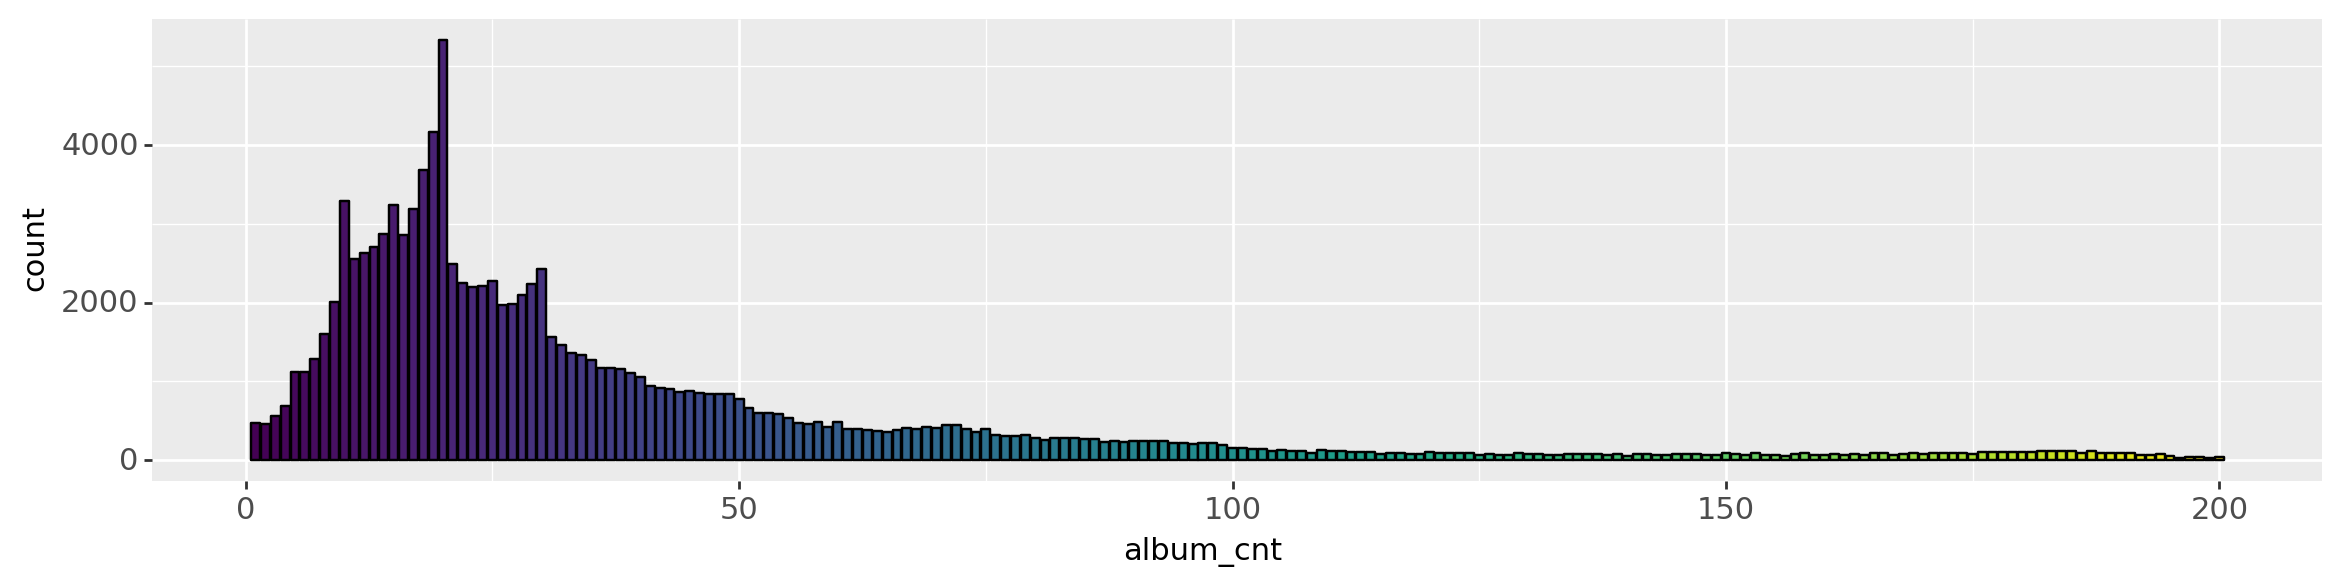

<ggplot: (8757982634900)>

In [ ]:
(ggplot(data = up_train) +
 stat_count(aes(x = 'album_cnt', fill = '..x..'), color = 'black', show_legend = 'F') +
 theme(text = element_text(fontproperties=font_name),
       figure_size=(14, 3))
 )

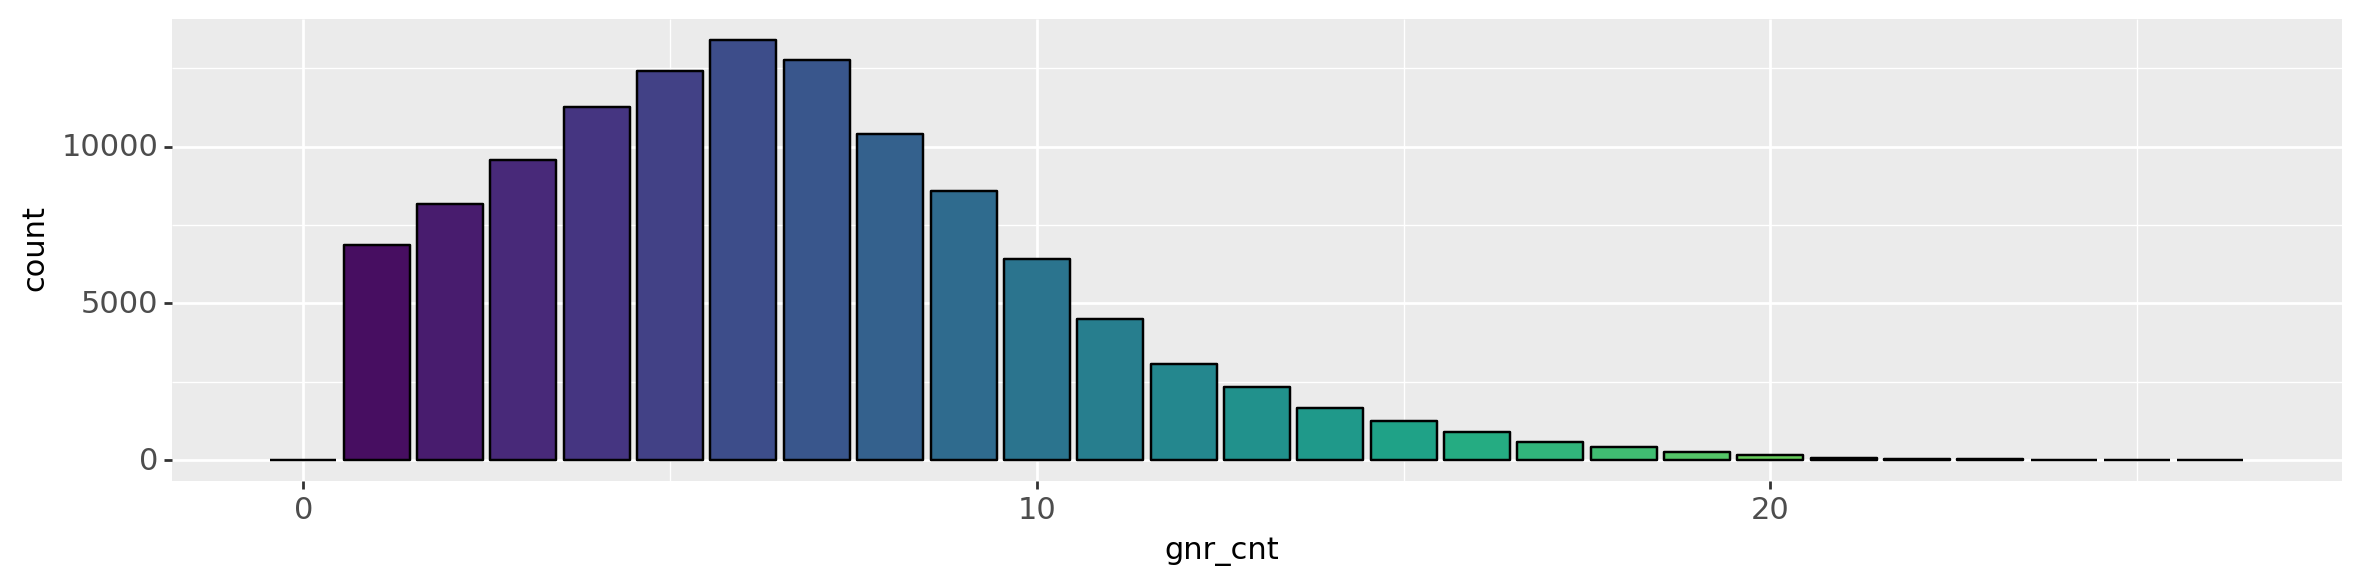

<ggplot: (8757982539328)>

In [ ]:
(ggplot(data = up_train) +
 stat_count(aes(x = 'gnr_cnt', fill = '..x..'), color = 'black', show_legend = 'F') +
 theme(text = element_text(fontproperties=font_name),
       figure_size=(14, 3))
 )

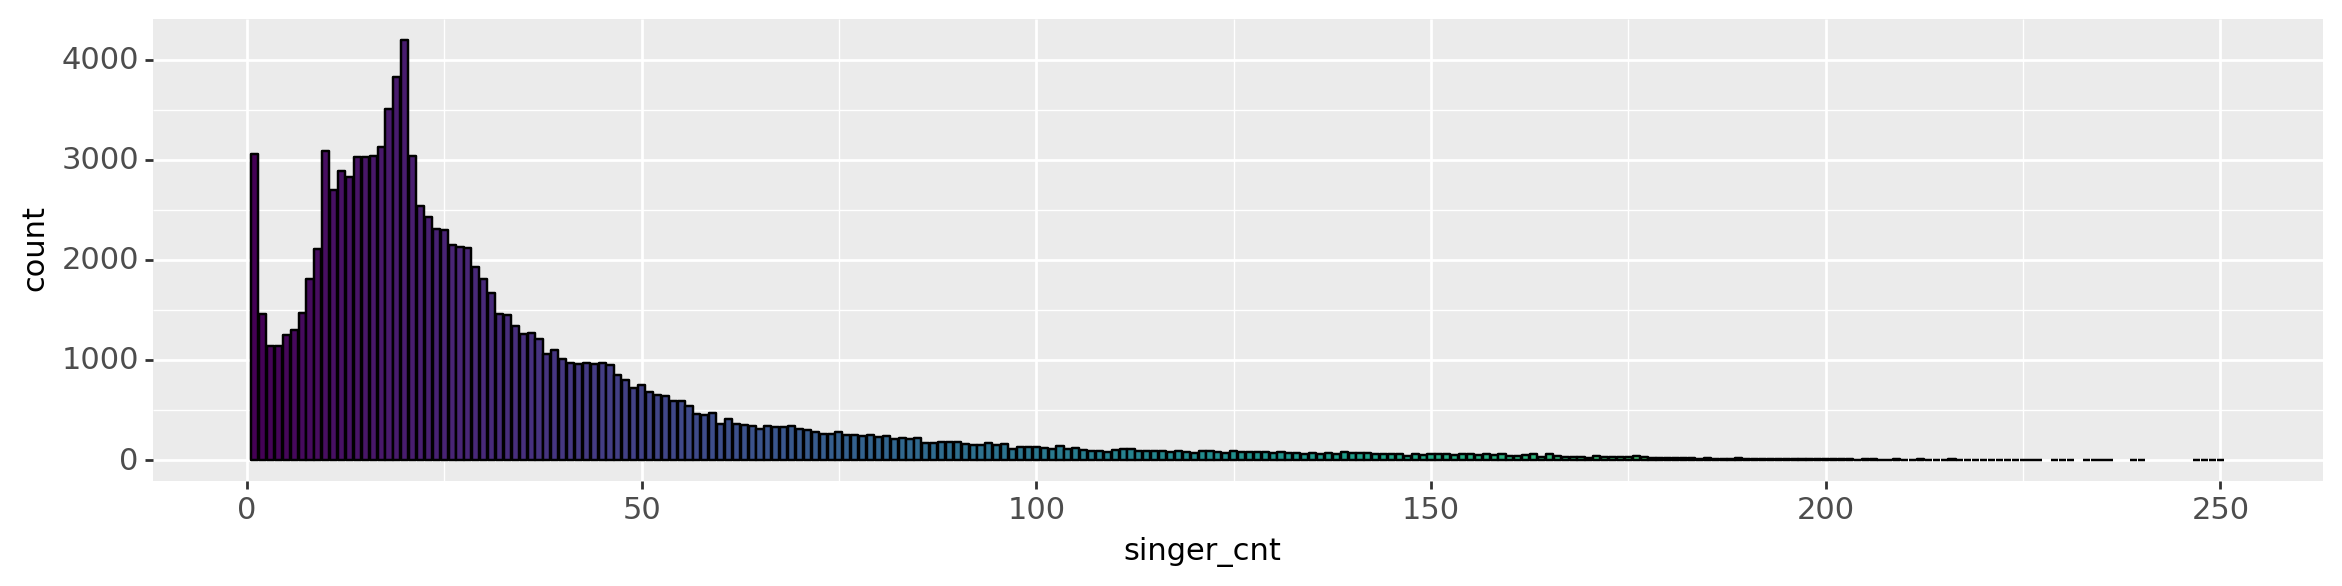

<ggplot: (-9223363278872274025)>

In [ ]:
(ggplot(data = up_train) +
 stat_count(aes(x = 'singer_cnt', fill = '..x..'), color = 'black', show_legend = 'F') +
 theme(text = element_text(fontproperties=font_name),
       figure_size=(14, 3))
 )

In [ ]:
# issue_date가 1997-07-00인 앨범들이 존재함 -> 분석필요
song_meta.query('issue_date == 19970700')

,song_gn_dtl_gnr_basket,issue_date,album_name,album_id,artist_id_basket,song_name,song_gn_gnr_basket,artist_name_basket,id
5561,"[GN1501, GN1504]",19970700,프로포즈 OST,9577,[6123],프로포즈,[GN1500],[M22N (홍지호)],5561
12604,"[GN0104, GN0101]",19970700,비상,357227,[4838],그대 ... 내게 와,[GN0100],[임재범],12604
36826,"[GN0104, GN0101]",19970700,비상,357227,[4838],추락,[GN0100],[임재범],36826
69651,"[GN0601, GN0604]",19970700,Dedicate,5183,[891],이제는,[GN0600],[홍경민],69651
84155,"[GN0701, GN0709]",19970700,어이/동창회/남자에게,4945,[42],낭만에 대하여,[GN0700],[최백호],84155
216503,"[GN0104, GN0101]",19970700,비상,357227,[4838],최선의 고백,[GN0100],[임재범],216503
227349,"[GN0701, GN0709]",19970700,어이/동창회/남자에게,4945,[42],어이,[GN0700],[최백호],227349
235339,[GN2004],19970700,아문적주제곡,30342,[33177],아문적주제곡,[GN2000],[정수문],235339
365100,"[GN1306, GN1301]",19970700,This Is Not A Love Song,367901,[231944],Say Nothin` (Original Ver.),[GN1300],[Omar],365100
379972,"[GN0104, GN0101]",19970700,비상,357227,[4838],사랑보다 깊은 상처,[GN0100],[임재범],379972


In [ ]:
song_meta.issue_date.describe().to_frame().astype(int)

,issue_date
count,707989
mean,20033938
std,1263819
min,0
25%,20080627
50%,20140325
75%,20170228
max,20220113


In [ ]:
song_meta.query('issue_date > 20200500')

,song_gn_dtl_gnr_basket,issue_date,album_name,album_id,artist_id_basket,song_name,song_gn_gnr_basket,artist_name_basket,id
141185,[GN1801],20220113,고요한 밤바다 구경하기 [여수 바다],10403230,[2737142],잔잔한 바람이 불어와 (There is a gentle breeze),[GN1800],[무드홀릭 (Moodholic)],141185
448286,[GN1801],20220113,고요한 밤바다 구경하기 [여수 바다],10403230,[2737142],여수 바다 (Yeosu sea),[GN1800],[무드홀릭 (Moodholic)],448286


In [ ]:
song_meta.query('issue_date < 19600000')

,song_gn_dtl_gnr_basket,issue_date,album_name,album_id,artist_id_basket,song_name,song_gn_gnr_basket,artist_name_basket,id
562,"[GN0906, GN0901]",0,MTV Unplugged,65244,[2350],Summer Of `69,[GN0900],[Bryan Adams],562
714,"[GN1701, GN1704]",19580101,Au Club St. Germain 1958,313162,[27128],Politely,[GN1700],[Art Blakey],714
785,[GN1801],0,The Letter,8177,[101554],기다림 (Missing You),[GN1800],[안단테],785
1543,[GN0701],0,한국(韓國) 최고가수(最高歌手) 36인 여자가수편(女子歌手篇),30431,[40],만남,[GN0700],[노사연],1543
1730,"[GN1013, GN0901, GN0902, GN1001]",0,Bury The Hatchet: The Complete Sessions,22367,[100250],Promises,"[GN0900, GN1000]",[Cranberries],1730
...,...,...,...,...,...,...,...,...,...
707483,[GN1701],0,Godchild,130164,[3658],Bag`s Groove,[GN1700],[Miles Davis],707483
707515,[GN1701],0,Reckless Precision,35135,[2315],(Somewhere) Over The Rainbow/If I Only Had A B...,[GN1700],[Tuck Andress],707515
707664,"[GN1701, GN1702]",19560403,Black Coffee With Peggy Lee,348371,[28566],I Didn`t Know What Time It Was,[GN1700],[Peggy Lee],707664
707738,[GN0701],0,은방울자매 전곡 BEST HIT,315093,[100050],마포 종점,[GN0700],[은방울 자매],707738


In [ ]:
song_meta.query('issue_date == 0')

,song_gn_dtl_gnr_basket,issue_date,album_name,album_id,artist_id_basket,song_name,song_gn_gnr_basket,artist_name_basket,id
562,"[GN0906, GN0901]",0,MTV Unplugged,65244,[2350],Summer Of `69,[GN0900],[Bryan Adams],562
785,[GN1801],0,The Letter,8177,[101554],기다림 (Missing You),[GN1800],[안단테],785
1543,[GN0701],0,한국(韓國) 최고가수(最高歌手) 36인 여자가수편(女子歌手篇),30431,[40],만남,[GN0700],[노사연],1543
1730,"[GN1013, GN0901, GN0902, GN1001]",0,Bury The Hatchet: The Complete Sessions,22367,[100250],Promises,"[GN0900, GN1000]",[Cranberries],1730
2360,"[GN1006, GN1005, GN1013, GN1001]",0,The House Of Blue Light,65732,[103794],Hard Lovin&#39; Woman,[GN1000],[Deep Purple],2360
...,...,...,...,...,...,...,...,...,...
707473,[GN1701],0,Reckless Precision,35135,[2315],Man In The Mirror,[GN1700],[Tuck Andress],707473
707483,[GN1701],0,Godchild,130164,[3658],Bag`s Groove,[GN1700],[Miles Davis],707483
707515,[GN1701],0,Reckless Precision,35135,[2315],(Somewhere) Over The Rainbow/If I Only Had A B...,[GN1700],[Tuck Andress],707515
707738,[GN0701],0,은방울자매 전곡 BEST HIT,315093,[100050],마포 종점,[GN0700],[은방울 자매],707738


In [ ]:
up_train.min_date.apply(lambda x: datetime.strptime(str(x), '%Y%m%d'))

### 3.2 playlist title

### 3.3 songs

In [ ]:
# 플레이리스트에 포함된 곡 개수 분포
pd.Series(map(len, train.songs)).describe()

count    115071.000000
mean         45.935735
std          43.950335
min           1.000000
25%          19.000000
50%          30.000000
75%          54.000000
max         200.000000
dtype: float64

### 3.4 like count

In [ ]:
# 플레이리스트 '좋아요' 개수 분포
train.like_cnt.describe()

count    115071.000000
mean         95.197687
std         560.653757
min           0.000000
25%           2.000000
50%           7.000000
75%          24.000000
max       53211.000000
Name: like_cnt, dtype: float64

In [ ]:
train.query('like_cnt > 10000').sort_values('like_cnt', ascending = False).head()

,tags,id,plylst_title,songs,like_cnt,updt_date
46524,"[노동요, 취향저격, 드라이브, Pop, 기분전환, 트렌디, 스트레스, 신나는]",74220,HOT TRENDY POP: 놓쳐선 안될 'POP' (매주 업데이트),"[159317, 368264, 600999, 274905, 643023, 24070...",53211,2020-04-17 14:32:23.000
85071,"[감성, 새벽, 때껄룩, 잔잔한, 휴식, 팝송, 떼껄룩, 힐링, 팝, 신나는]",122388,❤️때껄룩님 ᴛᴀᴋᴇ ᴀ ʟᴏᴏᴋ 플레이리스트❤️,"[532771, 383775, 432753, 176384, 152694, 60126...",41844,2020-04-23 20:58:45.000
102651,"[매장음악, 카페, 러블리쏘, 분위기, 드라이브, 여행, 매력적인, 기분전환, 팝]",26174,듣다보면 '우와!' 하고 제목을 보게되는 팝,"[40160, 20039, 561488, 20051, 16242, 256568, 7...",27268,2020-04-19 21:22:11.000
101464,"[흥겨운, 드라이브, Pop, 기분전환, 경쾌한, 외출, 내적댄스, 기분업, 충전,...",72658,"약속 있어? 외출 전, 기분 UP 하고 싶을 때 들어봐! [매주 목요일]","[111779, 406878, 417725, 129878, 357770, 34879...",23965,2020-04-22 16:05:39.000
59894,"[힐링, 휴식, 기분전환]",113501,감성이 터지는 팝음악들,"[342524, 1233, 417666, 394523, 107455, 17206, ...",23732,2015-07-29 08:25:35.000


### 3.5 update date

In [ ]:
genre_gn_all[genre_gn_all['gnr_code'].str[-2:] == '01'].gnr_name.unique()

array(['세부장르전체', '유아동요', '가톨릭'], dtype=object)

In [ ]:
genre_gn_all.query('gnr_name in ["유아동요", "가톨릭"]')

,gnr_code,gnr_name
199,GN2201,유아동요
216,GN2301,가톨릭


In [ ]:
gnr_code = genre_gn_all[genre_gn_all['gnr_code'].str[-2:] == '00']

In [ ]:
print(gnr_code.shape)
gnr_code.head()

(30, 2)


,gnr_code,gnr_name
0,GN0100,발라드
6,GN0200,댄스
12,GN0300,랩/힙합
18,GN0400,R&B/Soul
22,GN0500,인디음악


In [ ]:
dtl_gnr_code = genre_gn_all[genre_gn_all['gnr_code'].str[-2:] != '00']
dtl_gnr_code.rename(columns = {'gnr_code' : 'dtl_gnr_code', 'gnr_name' : 'dtl_gnr_name'}, inplace = True)

In [ ]:
print(dtl_gnr_code.shape)
dtl_gnr_code.head()

(224, 2)


,dtl_gnr_code,dtl_gnr_name
1,GN0101,세부장르전체
2,GN0102,'80
3,GN0103,'90
4,GN0104,'00
5,GN0105,'10-


In [ ]:
gnr_code = gnr_code.assign(join_code = gnr_code['gnr_code'].str[0:4])
dtl_gnr_code = dtl_gnr_code.assign(join_code = dtl_gnr_code['dtl_gnr_code'].str[0:4])

gnr_code_tree = pd.merge(gnr_code, dtl_gnr_code, how = 'left', on = 'join_code').drop(columns = 'join_code')

In [ ]:
print(gnr_code_tree.shape)
gnr_code_tree.head()

(225, 4)


,gnr_code,gnr_name,dtl_gnr_code,dtl_gnr_name
0,GN0100,발라드,GN0101,세부장르전체
1,GN0100,발라드,GN0102,'80
2,GN0100,발라드,GN0103,'90
3,GN0100,발라드,GN0104,'00
4,GN0100,발라드,GN0105,'10-


In [ ]:
gnr_code_tree[gnr_code_tree['gnr_code'] == 'GN0900']

,gnr_code,gnr_name,dtl_gnr_code,dtl_gnr_name
48,GN0900,POP,GN0901,세부장르전체
49,GN0900,POP,GN0902,얼터너티브팝
50,GN0900,POP,GN0903,올디스
51,GN0900,POP,GN0904,월드팝
52,GN0900,POP,GN0905,'60-'70
53,GN0900,POP,GN0906,'80-'90
54,GN0900,POP,GN0907,'00
55,GN0900,POP,GN0908,'10-


In [ ]:
song_meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 707989 entries, 0 to 707988
Data columns (total 9 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   song_gn_dtl_gnr_basket  707989 non-null  object
 1   issue_date              707989 non-null  int64 
 2   album_name              707985 non-null  object
 3   album_id                707989 non-null  int64 
 4   artist_id_basket        707989 non-null  object
 5   song_name               707989 non-null  object
 6   song_gn_gnr_basket      707989 non-null  object
 7   artist_name_basket      707989 non-null  object
 8   id                      707989 non-null  int64 
dtypes: int64(3), object(6)
memory usage: 48.6+ MB


In [ ]:
print(song_meta.shape)
song_meta.head()

(707989, 9)


,song_gn_dtl_gnr_basket,issue_date,album_name,album_id,artist_id_basket,song_name,song_gn_gnr_basket,artist_name_basket,id
0,[GN0901],20140512,불후의 명곡 - 7080 추억의 얄개시대 팝송베스트,2255639,[2727],Feelings,[GN0900],[Various Artists],0
1,"[GN1601, GN1606]",20080421,"Bach : Partitas Nos. 2, 3 & 4",376431,[29966],"Bach : Partita No. 4 In D Major, BWV 828 - II....",[GN1600],[Murray Perahia],1
2,[GN0901],20180518,Hit,4698747,[3361],Solsbury Hill (Remastered 2002),[GN0900],[Peter Gabriel],2
3,"[GN1102, GN1101]",20151016,Feeling Right (Everything Is Nice) (Feat. Popc...,2644882,[838543],Feeling Right (Everything Is Nice) (Feat. Popc...,[GN1100],[Matoma],3
4,"[GN1802, GN1801]",20110824,그남자 그여자,2008470,[560160],그남자 그여자,[GN1800],[Jude Law],4


In [ ]:
# 노래 메타 데이터 장르 대분류 개수 분포
pd.Series(map(len, song_meta.song_gn_gnr_basket)).describe()

count    707989.000000
mean          1.133999
std           0.352603
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           6.000000
dtype: float64

In [ ]:
# 노래 메타 데이터 장르 세부분류 개수 분포
pd.Series(map(len, song_meta.song_gn_dtl_gnr_basket)).describe()

count    707989.000000
mean          2.136184
std           1.135780
min           0.000000
25%           1.000000
50%           2.000000
75%           3.000000
max          12.000000
dtype: float64

In [ ]:
song_meta[song_meta.album_name.isna()]

,song_gn_dtl_gnr_basket,issue_date,album_name,album_id,artist_id_basket,song_name,song_gn_gnr_basket,artist_name_basket,id
143209,"[GN0501, GN0601, GN0503, GN0606, GN0509]",20150522,None,2318271,[726168],사랑바보,"[GN0500, GN0600]",[민은서밴드],143209
291631,"[GN0105, GN0101]",20101108,None,1065178,[28772],빗속에서,[GN0100],[존박],291631
431110,"[GN0509, GN0601, GN0503, GN0606, GN0501]",20200208,None,10385717,[2203064],화면,"[GN0500, GN0600]",[Oowl Hannal (우울 한날)],431110
552088,"[GN0105, GN0601]",20101108,None,1065178,[28263],본능적으로 (Feat. Swings),"[GN0600, GN0100]",[강승윤],552088


In [ ]:
song_meta[song_meta.album_name.notna() & song_meta.album_name.str.contains('불후의 명곡 -')]

,song_gn_dtl_gnr_basket,issue_date,album_name,album_id,artist_id_basket,song_name,song_gn_gnr_basket,artist_name_basket,id
0,[GN0901],20140512,불후의 명곡 - 7080 추억의 얄개시대 팝송베스트,2255639,[2727],Feelings,[GN0900],[Various Artists],0
573,"[GN0601, GN0606]",20150117,불후의 명곡 - 전설을 노래하다 (가족은 즐겁다),2300255,[747270],회상,[GN0600],[서지안],573
1797,"[GN0105, GN0101]",20160903,불후의 명곡 - 전설을 노래하다 (드라마 OST 특집 편),2708842,[38141],My Destiny,[GN0100],[임태경],1797
2038,[GN1501],20150722,불후의 명곡 - 뮤지컬 명예의 전당,2330769,[842312],Luck Be A Lady (아가씨와 건달들),[GN1500],[Cast],2038
2163,[GN0101],20180203,불후의 명곡 - 전설을 노래하다 (김연자&이호섭 편),10136119,[658092],짝사랑,[GN0100],[유성은],2163
...,...,...,...,...,...,...,...,...,...
703751,"[GN0601, GN0606]",20160924,불후의 명곡 - 전설을 노래하다 (쉘부르 특집 1부),10000869,[107725],사랑의 진실,[GN0600],[클래지콰이],703751
704120,"[GN0105, GN0101]",20160423,불후의 명곡 - 전설을 노래하다 (봄노래 특집),2681326,[8530],찔레꽃,[GN0100],[린],704120
705284,"[GN0601, GN0606]",20160702,불후의 명곡 - 전설을 노래하다 (2016 상반기 결산 7인의 빅매치),2695226,[895],영원히 내게,[GN0600],[김경호],705284
705857,"[GN0105, GN0101]",20160206,불후의 명곡 - 전설을 노래하다 (설 특집),2666232,[27033],그대 내게 다시,[GN0100],[별],705857


In [ ]:
song_meta.iloc[707801].album_name

'Roman Holiday : Canzone & Chanson Best  (로마의 휴일 - 불후의 명곡 영화 속 7080 칸쵸네 & 샹송 베스트)'

In [ ]:
# 곡 아이디(id)와 대분류 장르코드 리스트(song_gn_gnr_basket) 추출
song_gnr_map = song_meta.filter(items = ['id', 'song_gn_gnr_basket'])

# unnest song_gn_gnr_basket
song_gnr_map_unnest = song_gnr_map.explode('song_gn_gnr_basket').reset_index(drop = True)

# unnested 데이터프레임 생성 : song_gnr_map
#song_gnr_map = pd.DataFrame(data = song_gnr_map_unnest[0], columns = song_gnr_map.columns)
song_gnr_map = song_gnr_map_unnest\
  .assign(id = lambda df: df.id.astype(str))\
  .rename(columns = {'id': 'song_id', 'song_gn_gnr_basket': 'gnr_code'})

# unnest 객체 제거
del song_gnr_map_unnest

In [ ]:
song_gnr_map.head()

,song_id,gnr_code
0,0,GN0900
1,1,GN1600
2,2,GN0900
3,3,GN1100
4,4,GN1800


In [ ]:
song_gnr_map[song_gnr_map['gnr_code'].str[-2:] == '01']

,song_id,gnr_code


In [ ]:
# 1. 곡 별 장르 개수 count 테이블 생성 : song_gnr_count
song_gnr_count = song_gnr_map.groupby('song_id').gnr_code.nunique().reset_index(name = 'mapping_gnr_cnt')

# 2. 1번에서 생성한 테이블을 가지고 매핑된 장르 개수 별 곡 수 count 테이블 생성 : gnr_song_count
gnr_song_count = song_gnr_count.groupby('mapping_gnr_cnt').song_id.nunique().reset_index(name = '매핑된 곡 수')

# 3. 2번 테이블에 비율 값 추가
gnr_song_count.loc[:, '비율(%)'] = round(gnr_song_count['매핑된 곡 수']/sum(gnr_song_count['매핑된 곡 수'])*100, 2)
gnr_song_count = gnr_song_count.rename(columns = {'mapping_gnr_cnt' : '장르 수'})
#gnr_song_count = gnr_song_count.reset_index().rename(columns = {'mapping_gnr_cnt' : '장르 수'})
#gnr_song_count[['장르 수', '매핑된 곡 수', '비율(%)']]
gnr_song_count

,장르 수,매핑된 곡 수,비율(%)
0,0,1059,0.15
1,1,612806,86.56
2,2,92378,13.05
3,3,1694,0.24
4,4,48,0.01
5,5,1,0.00
6,6,3,0.00


In [ ]:
song_gnr_count.query('mapping_gnr_cnt >= 5')

,song_id,mapping_gnr_cnt
16062,114452,6
70021,163015,6
97009,187305,6
700211,92999,5


In [ ]:
song_meta[song_meta['id'] == 456506]

,song_gn_dtl_gnr_basket,issue_date,album_name,album_id,artist_id_basket,song_name,song_gn_gnr_basket,artist_name_basket,id
456506,"[GN0403, GN0101, GN1501, GN1504]",20060731,오버 더 레인보우 OST,321962,[1928],그리운 건 어쩔 수 없어,"[GN0400, GN1500, GN0100]",[환희],456506


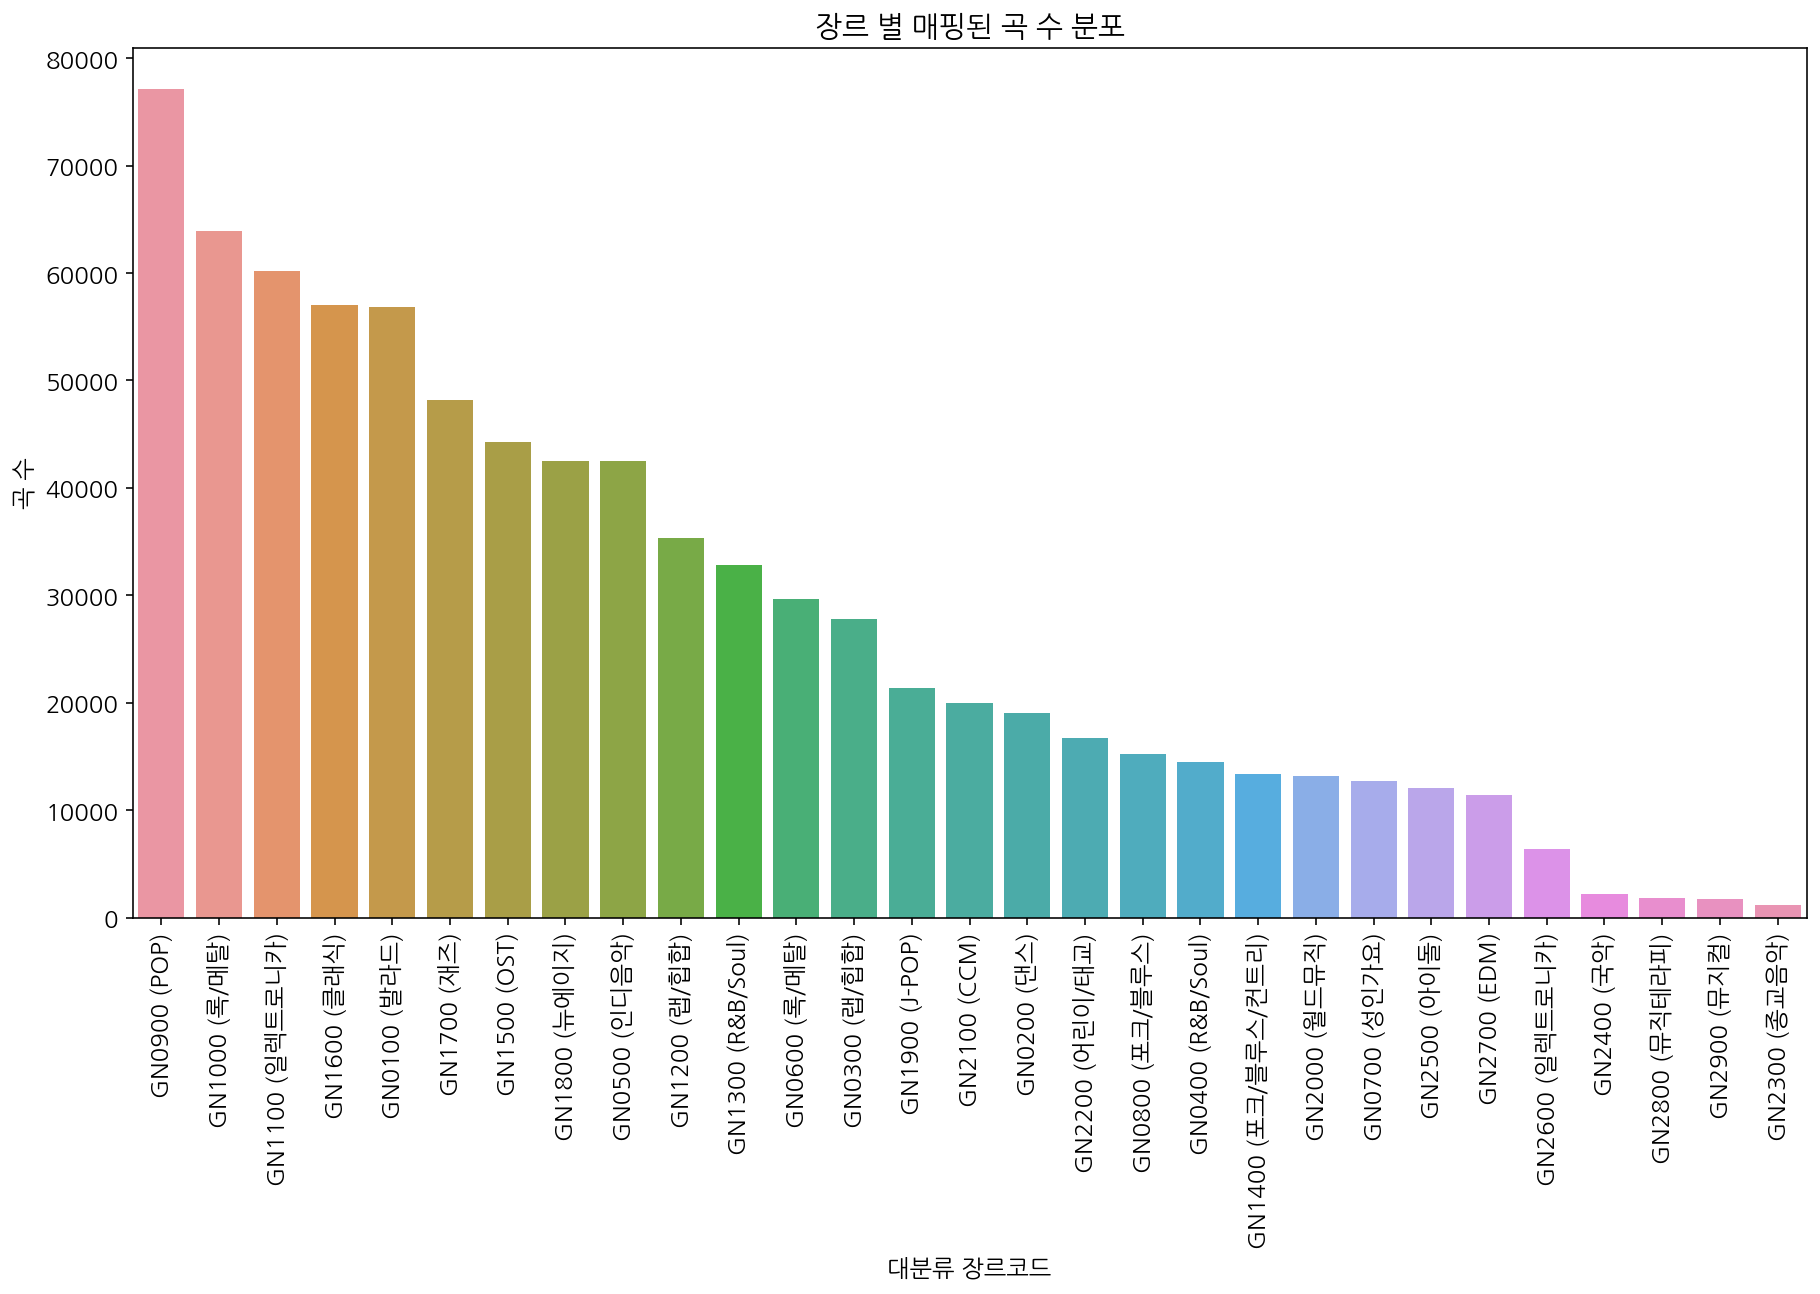

In [ ]:
# 1. 장르 별 곡 수 count 테이블 생성 : gnr_count
gnr_count = song_gnr_map.groupby('gnr_code').song_id.nunique().reset_index(name = 'song_cnt')

# 2. 1번 테이블과 장르 meta와 join
gnr_count = pd.merge(gnr_count, gnr_code.loc[:, ['gnr_code', 'gnr_name']], how = 'left', on = 'gnr_code')
gnr_count['gnr_code_name'] = gnr_count['gnr_code'] + ' (' + gnr_count['gnr_name'] + ')'

# 3. 매핑이 되지 않은 일부 곡들은 제거
gnr_count = gnr_count[['gnr_code_name', 'song_cnt']].dropna()

# 4. 많은 곡이 매핑된 순 기준으로 내림차순 리스트 생성
gnr_list_desc = gnr_count.sort_values('song_cnt', ascending = False).gnr_code_name

# 5. plotting
gnr_code_name_plot = sns.barplot(x = 'gnr_code_name', y = 'song_cnt', data = gnr_count, order = gnr_list_desc)
gnr_code_name_plot.set_title('장르 별 매핑된 곡 수 분포')
gnr_code_name_plot.set_xlabel('대분류 장르코드')
gnr_code_name_plot.set_ylabel('곡 수')
plt.xticks(rotation = 90)
plt.show()

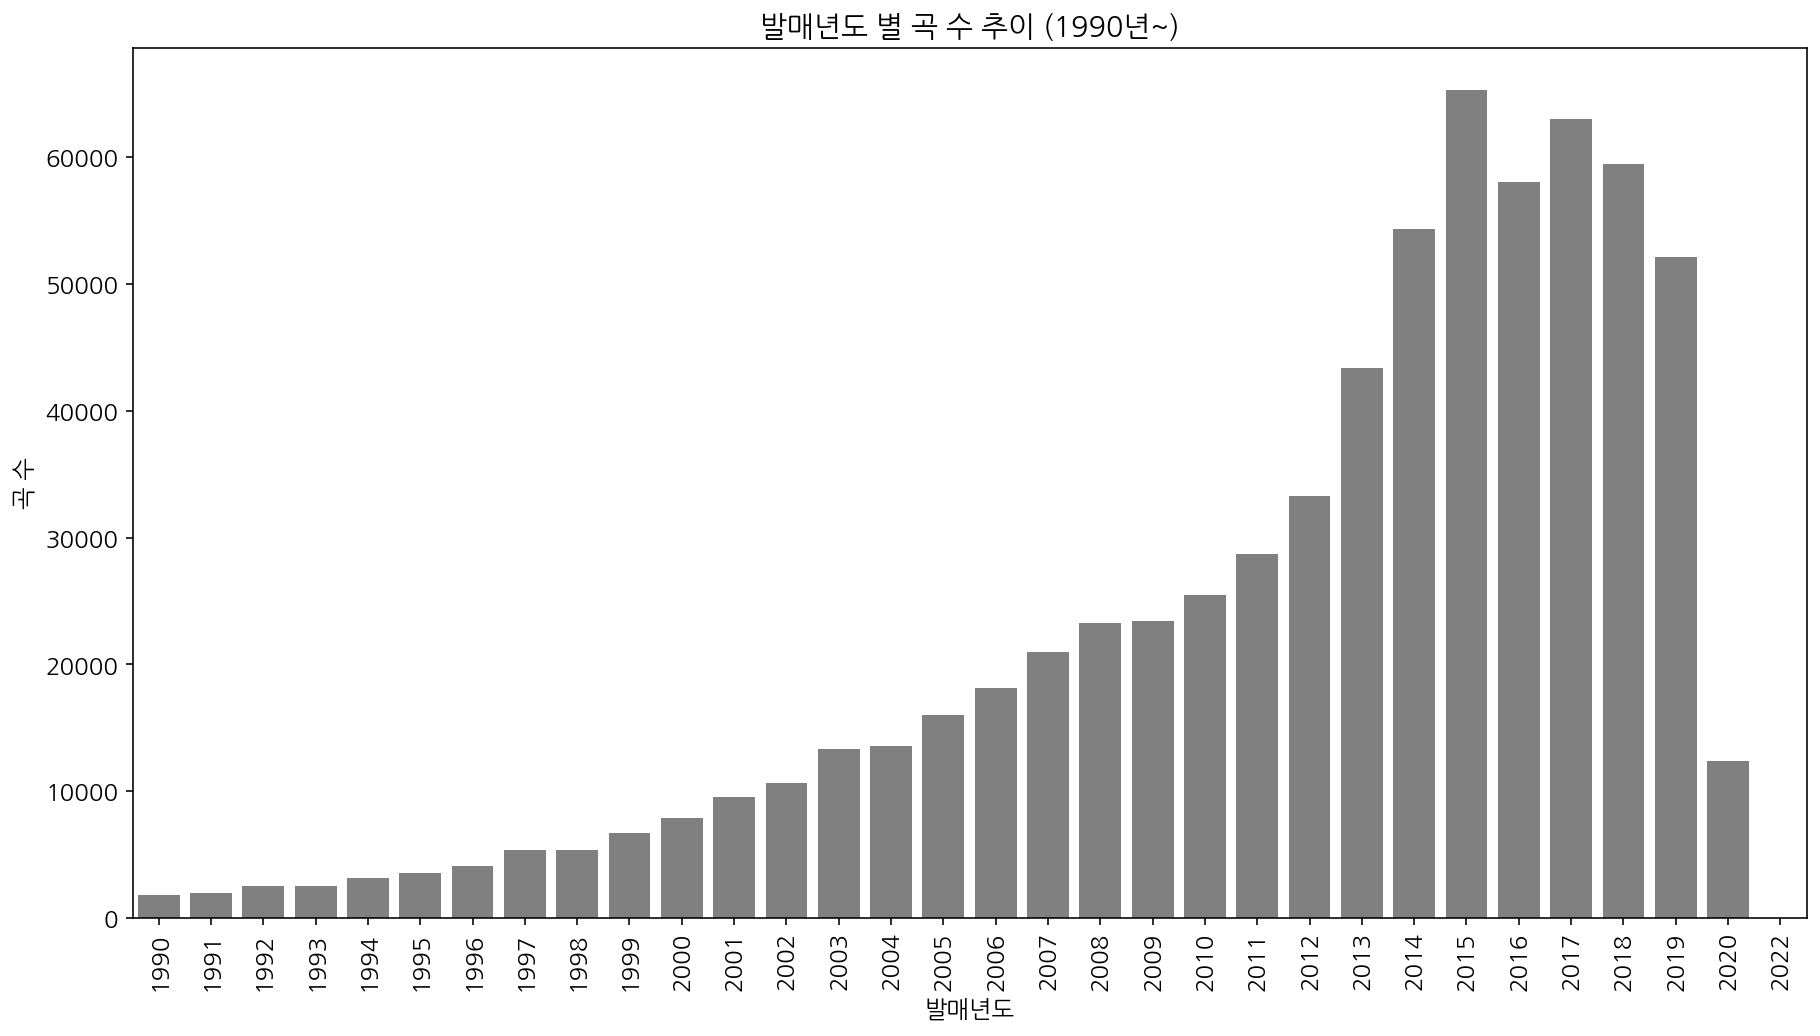

In [ ]:
# 1. 곡 아이디(id)와 발매일자(issue_date) 추출
song_issue_date = song_meta[['id', 'issue_date']]
song_issue_date['issue_date'] = song_issue_date['issue_date'].astype(str)

# 2. issue_date의 앞자리 네 자리를 추출하여 발매년도(issue_year) 변수 생성
song_issue_date['issue_year'] = song_issue_date['issue_date'].str[0:4]
song_issue_date.rename(columns = {'id' : 'song_id'}, inplace = True)
song_issue_date['song_id'] = song_issue_date['song_id'].astype(str)

# 3. 1990년도~ 필터링
song_issue_date_filter = song_issue_date[song_issue_date.issue_year >= '1990']

# 4. 발매년도 별 곡 수 count 테이블 생성 : issue_year_song_cnt
issue_year_song_cnt = song_issue_date_filter.groupby('issue_year').song_id.nunique().reset_index(name = 'song_cnt')

# 5. plotting
issue_year_song_cnt_plot = sns.barplot(x = 'issue_year', y = 'song_cnt', data = issue_year_song_cnt, color = 'grey')
issue_year_song_cnt_plot.set_title('발매년도 별 곡 수 추이 (1990년~)')
issue_year_song_cnt_plot.set_xlabel('발매년도')
issue_year_song_cnt_plot.set_ylabel('곡 수')
plt.xticks(rotation = 90)
plt.show()

In [ ]:
# 플레이리스트 아이디(id)와 수록곡(songs) 추출
plylst_song_map = train[['id', 'songs']]

# unnest songs
plylst_song_map_unnest = plylst_song_map.explode('songs').reset_index(drop = True)

# unnested 데이터프레임 생성 : plylst_song_map
plylst_song_map = plylst_song_map_unnest.assign(
    id = lambda df: df.id.astype(str),
    songs = lambda df: df.songs.astype(str)
)
# unnest 객체 제거
del plylst_song_map_unnest

In [ ]:
plylst_song_map.head()

,id,songs
0,61281,525514
1,61281,129701
2,61281,383374
3,61281,562083
4,61281,297861


In [ ]:
# 플레이리스트 아이디(id)와 매핑된 태그(tags) 추출
plylst_tag_map = train[['id', 'tags']]

# unnest tags
plylst_tag_map_unnest = plylst_tag_map.explode('tags').reset_index(drop = True)

# unnested 데이터프레임 생성 : plylst_tag_map
plylst_tag_map = plylst_tag_map_unnest.assign(
    id = lambda df: df.id.astype(str)
)

# unnest 객체 제거
del plylst_tag_map_unnest

In [ ]:
plylst_tag_map.head()

,id,tags
0,61281,락
1,10532,추억
2,10532,회상
3,76951,까페
4,76951,잔잔한


In [ ]:
pd.DataFrame(plylst_tag_map.tags.unique())

,0
0,락
1,추억
2,회상
3,까페
4,잔잔한
...,...
29155,사랑하고있을때
29156,우울해지고싶을때듣는노래
29157,gershwin
29158,슈가맨시즌3


In [ ]:
train_uniq_song_cnt = plylst_song_map.songs.nunique() # 유니크 곡 수
train_uniq_tag_cnt = plylst_tag_map.tags.nunique() # 유니크 태그 수

print('곡 수 : %s' %train_uniq_song_cnt)
print('태그 수 : %s' %train_uniq_tag_cnt)

곡 수 : 615142
태그 수 : 29160


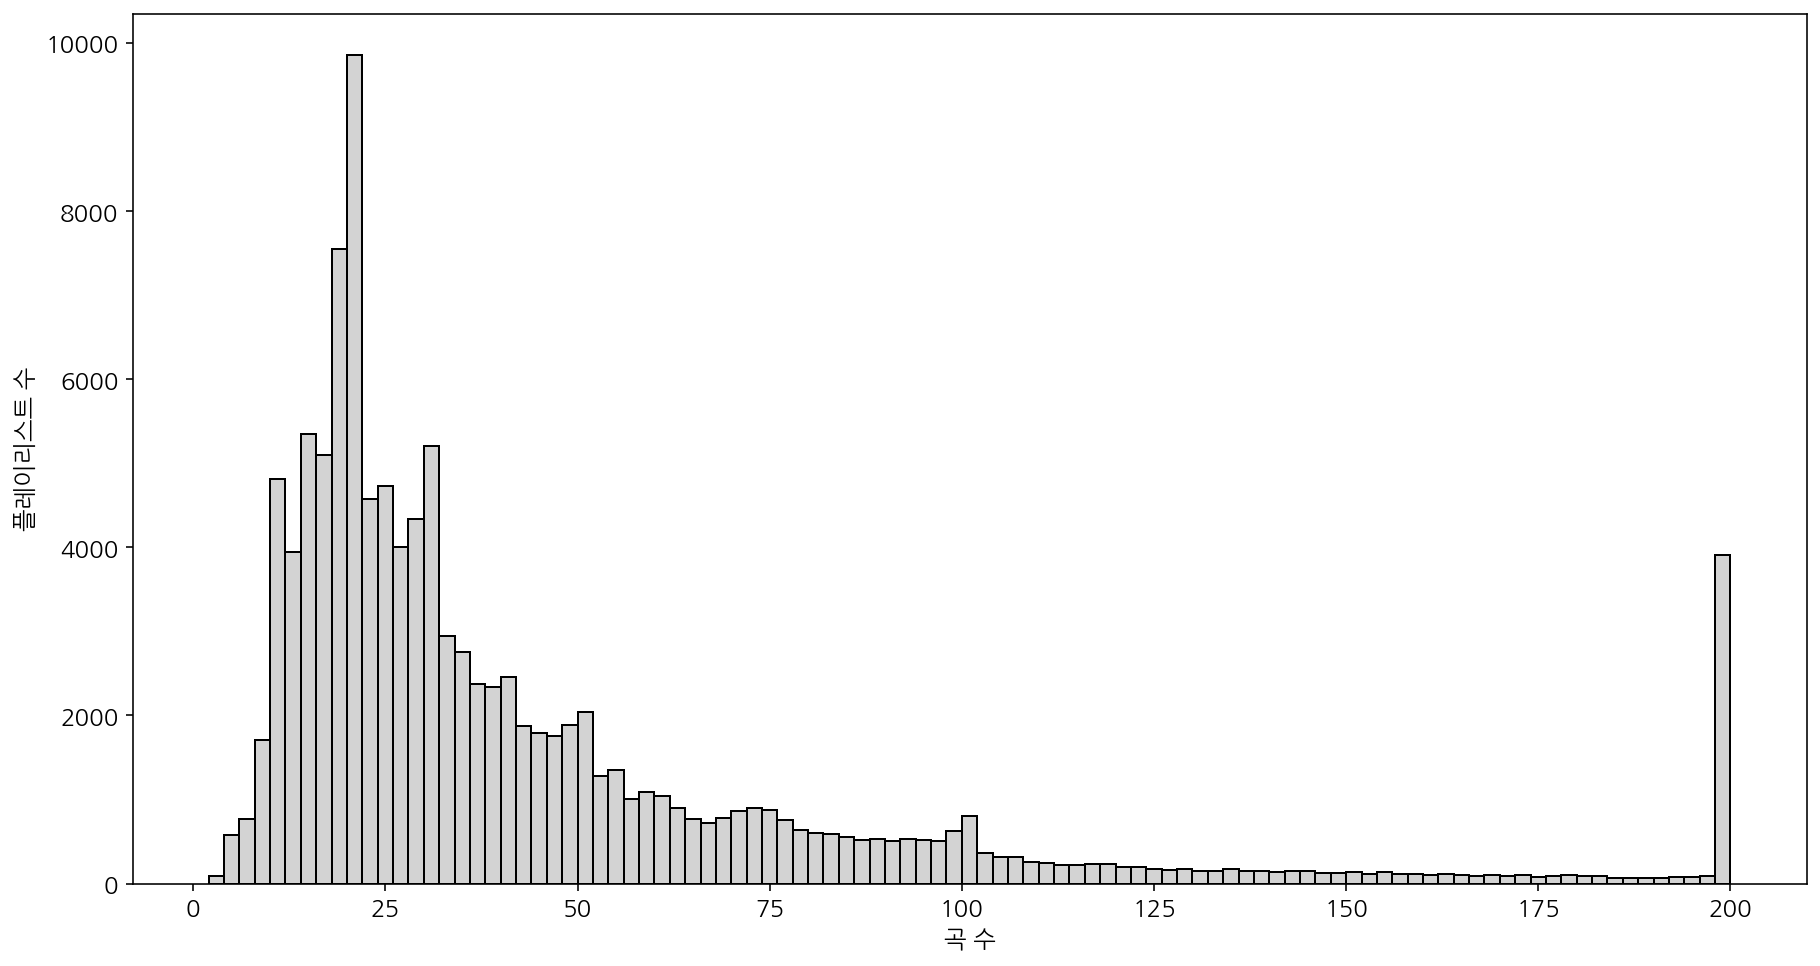

In [ ]:
# 1. 플레이리스트 별 수록곡 수 count 테이블 생성 : plylst_song_cnt
plylst_song_cnt = pd.DataFrame(plylst_song_map.groupby('id').songs.nunique())

# 2-1. grid setting
grid_list = [i*2 for i in range(1, 101)]

# 2-2. plotting
plt.hist(plylst_song_cnt['songs'], grid_list, color = "lightgrey", edgecolor = "black")
plt.xlabel('곡 수')
plt.ylabel('플레이리스트 수')
plt.show()

In [ ]:
round(plylst_song_cnt.describe().loc[['min', '25%', '50%', 'mean', '75%', 'max', 'std']].transpose(), 2)

,min,25%,50%,mean,75%,max,std
songs,1.0,19.0,30.0,45.94,54.0,200.0,43.95


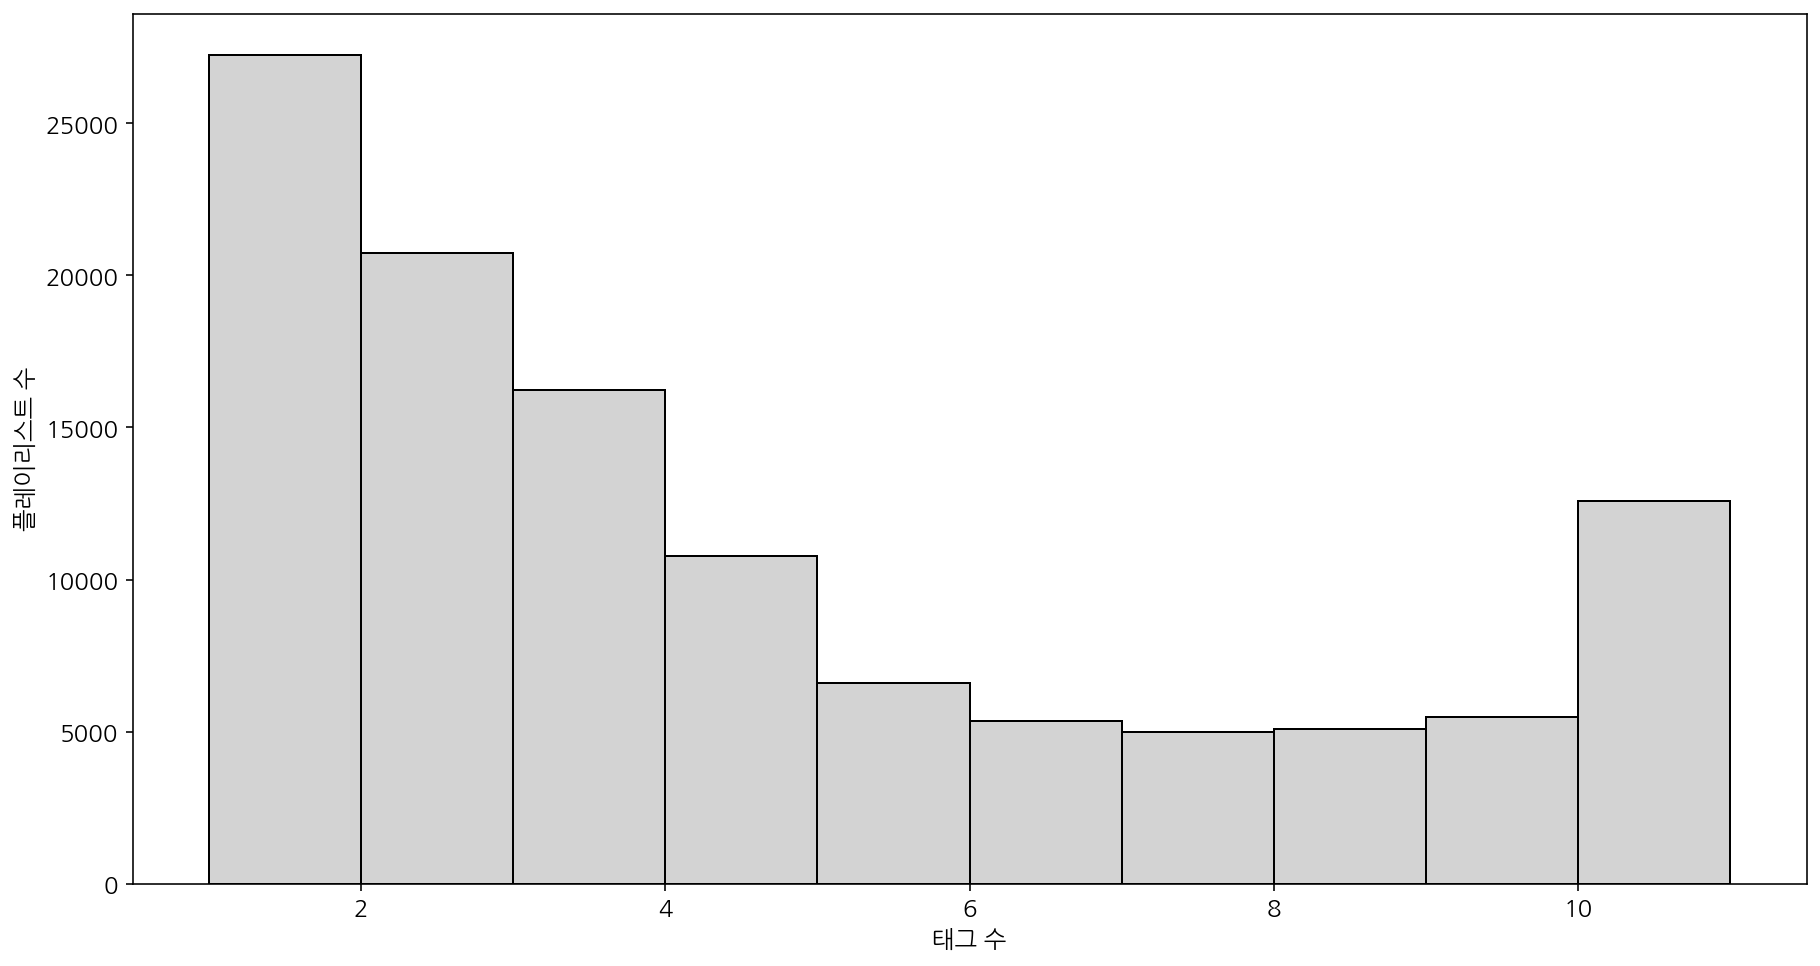

In [ ]:
# 1. 플레이리스트 별 매핑 태그 수 count 테이블 생성 : plylst_tag_cnt
plylst_tag_cnt = pd.DataFrame(plylst_tag_map.groupby('id').tags.nunique())

# 2. plotting
plt.hist(plylst_tag_cnt['tags'], range(1, 12), color = "lightgrey", edgecolor = "black")
plt.xlabel('태그 수')
plt.ylabel('플레이리스트 수')
plt.show()

In [ ]:
round(plylst_tag_cnt.describe().loc[['min', '25%', '50%', 'mean', '75%', 'max', 'std']].transpose(), 2)

,min,25%,50%,mean,75%,max,std
tags,1.0,2.0,3.0,4.14,6.0,11.0,3.07


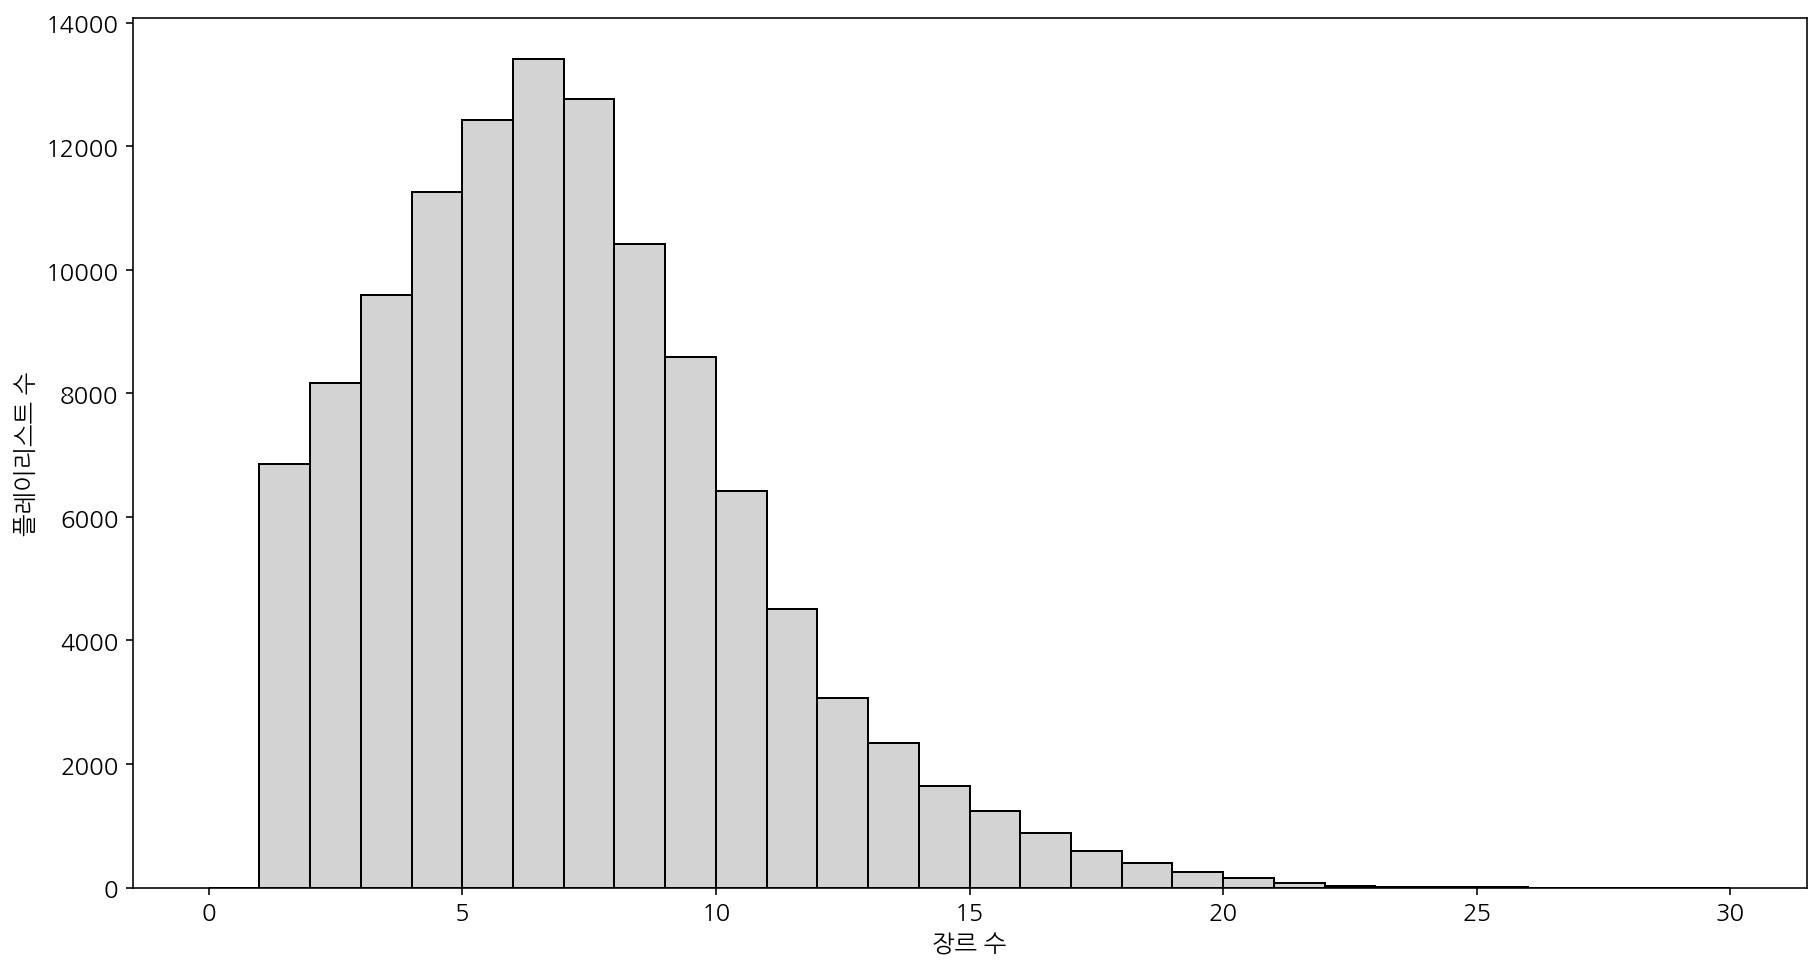

In [ ]:
# 1-1. join 목적으로 곡 아이디 integer to string 변환
plylst_song_map['songs'] = plylst_song_map['songs'].astype(str)

# 1-2. 플레이리스트-곡 테이블 plylst_song_map + 곡-장르 테이블 song_gnr_map join
plylst_song_gnr_map = pd.merge(plylst_song_map, song_gnr_map, how = 'left', left_on = 'songs', right_on = 'song_id')

# 2. 플레이리스트 별 곡 장르 수 count 테이블 생성 : plylst_song_gnr_cnt
plylst_song_gnr_cnt = pd.DataFrame(plylst_song_gnr_map.groupby('id').gnr_code.nunique())

# 3. plotting
plt.hist(plylst_song_gnr_cnt['gnr_code'], range(0, 31), color = "lightgrey", edgecolor = "black")
plt.xlabel('장르 수')
plt.ylabel('플레이리스트 수')
plt.show()

In [ ]:
round(plylst_song_gnr_cnt.describe().loc[['min', '25%', '50%', 'mean', '75%', 'max', 'std']].transpose(), 2)

,min,25%,50%,mean,75%,max,std
gnr_code,0.0,4.0,6.0,6.55,9.0,26.0,3.62


In [ ]:
# 1. 곡 별 수록된 플레이리스트 개수 count 테이블 생성 : song_plylst_cnt
song_plylst_cnt = plylst_song_map.groupby('songs').id.nunique().reset_index(name = 'mapping_plylst_cnt')

# 2. 단일/중복 수록 구분 : 곡 별 수록된 플레이리스트가 한 개면 '단일 수록', 두 개 이상이면 '중복 수록'
song_plylst_cnt = song_plylst_cnt.assign(
    mapping_plylst_cnt_category = pd.cut(song_plylst_cnt['mapping_plylst_cnt'], [0, 1, np.inf], labels = ['단일 수록', '중복 수록'])
)

# 3. 단일/중복 수록 구분 별 곡 수 count 테이블 생성 : song_plylst_mapping_division
song_plylst_mapping_division = pd.DataFrame(song_plylst_cnt.groupby('mapping_plylst_cnt_category').count())

# 4. 3번 테이블에 비율 값 추가
song_plylst_mapping_division.rename(columns = {'songs' : '곡 수'}, inplace = True)
song_plylst_mapping_division.loc[:, '비율(%)'] = round(song_plylst_mapping_division['곡 수']/sum(song_plylst_mapping_division['곡 수'])*100, 2)
song_plylst_mapping_division = song_plylst_mapping_division.reset_index().rename(columns = {'mapping_plylst_cnt_category' : '중복 수록 여부'})
song_plylst_mapping_division[['중복 수록 여부', '곡 수', '비율(%)']]

,중복 수록 여부,곡 수,비율(%)
0,단일 수록,299028,48.61
1,중복 수록,316114,51.39


In [ ]:
# 1. song_plylst_cnt 테이블에서 중복 수록 곡 중 수록 횟수 기준 상위 30곡 필터링 테이블 생성 : duplicate_song_top30
duplicate_song_top30 = song_plylst_cnt[song_plylst_cnt['mapping_plylst_cnt_category'] == '중복 수록'].nlargest(30, 'mapping_plylst_cnt')

# 2-1. join 목적으로 곡 아이디 integer to string 변환
duplicate_song_top30['songs'] = duplicate_song_top30['songs'].astype(str)
song_meta['id'] = song_meta['id'].astype(str)

# 2-2 상위 30곡 테이블 duplicate_song_top30 + 곡 메타 song_meta join
(
    pd.merge(duplicate_song_top30, song_meta[['id', 'song_name', 'artist_name_basket']],
             how = 'left', left_on = 'songs', right_on = 'id')
    [['songs', 'song_name', 'artist_name_basket', 'mapping_plylst_cnt']]
    .rename(columns = {'songs' : '곡 아이디', 'song_name' : '곡 명', 'artist_name_basket' : '아티스트 명', 'mapping_plylst_cnt' : '수록 횟수'})
)

,곡 아이디,곡 명,아티스트 명,수록 횟수
0,144663,밤편지,[아이유],2175
1,116573,안아줘,[정준일],2121
2,357367,비,[폴킴],1981
3,366786,가끔 미치도록 네가 안고 싶어질 때가 있어,[가을방학],1919
4,654757,눈의 꽃,[박효신],1647
5,133143,"그대와 나, 설레임 (Feat. 소울맨)",[어쿠스틱 콜라보],1633
6,349492,어떤이별,[임승부],1599
7,675115,야생화,[박효신],1598
8,463173,비가 내렸어 (Vocal by 스티브언니),[업라이트 (Upright)],1544
9,42155,벙어리,[홍아],1540


In [ ]:
# 1. song_plylst_cnt 테이블에서 단일 수록 곡만 필터링 하여 테이블 생성 : single_song
single_song = song_plylst_cnt[song_plylst_cnt['mapping_plylst_cnt_category'] == '단일 수록']

# 2-1. join 목적으로 곡 아이디 integer to string 변환
single_song['songs'] = single_song['songs'].astype(str)

# 2-2. 단일 수록 곡 테이블 single_song + 곡 메타 song_meta join : 아티스트 기준 single_song_artist, 장르 기준 single_song_gnr
single_song_artist = pd.merge(single_song, song_meta[['id', 'song_name', 'artist_name_basket']], how = 'left', left_on = 'songs', right_on = 'id')
single_song_gnr = pd.merge(single_song, song_gnr_map, how = 'left', left_on = 'songs', right_on = 'song_id')

# 3. 수록 곡 개수 기준 상위 30개 장르 : single_song_gnr_cnt
single_song_gnr_cnt = single_song_gnr.groupby('gnr_code').songs.nunique().reset_index(name = 'song_cnt')
(
    pd.merge(single_song_gnr_cnt, genre_gn_all, how = 'left', on = 'gnr_code')[['gnr_code', 'gnr_name', 'song_cnt']]
    .rename(columns = {'gnr_code' : '대분류 장르코드', 'gnr_name' : '장르명', 'song_cnt' : '수록 곡 수'})
    .sort_values('수록 곡 수', ascending = False)
)

,대분류 장르코드,장르명,수록 곡 수
15,GN1600,클래식,32841
8,GN0900,POP,30987
9,GN1000,록/메탈,30028
10,GN1100,일렉트로니카,25725
16,GN1700,재즈,23158
17,GN1800,뉴에이지,19370
14,GN1500,OST,16855
11,GN1200,랩/힙합,15054
0,GN0100,발라드,14575
12,GN1300,R&B/Soul,13136


In [ ]:
# 1. 태그 별 수록된 플레이리스트 개수 count 테이블 생성 : tag_plylst_cnt
tag_plylst_cnt = plylst_tag_map.groupby('tags').id.nunique().reset_index(name = 'mapping_plylst_cnt')

# 2. 단일/중복 매핑 구분 : 태그 별 매핑된 플레이리스트가 한 개면 '단일 매핑', 두 개 이상이면 '중복 매핑'
tag_plylst_cnt = tag_plylst_cnt.assign(
    mapping_plylst_cnt_category = pd.cut(tag_plylst_cnt['mapping_plylst_cnt'], [0, 1, np.inf], labels = ['단일 매핑', '중복 매핑'])
)

# 3. 단일/중복 매핑 구분 별 태그 수 count 테이블 생성 : tag_plylst_mapping_division
tag_plylst_mapping_division = pd.DataFrame(tag_plylst_cnt.groupby('mapping_plylst_cnt_category').count())

# 4. 3번 테이블에 비율 값 추가
tag_plylst_mapping_division.rename(columns = {'tags' : '태그 수'}, inplace = True)
tag_plylst_mapping_division.loc[:, '비율(%)'] = round(tag_plylst_mapping_division['태그 수']/sum(tag_plylst_mapping_division['태그 수'])*100, 2)
tag_plylst_mapping_division = tag_plylst_mapping_division.reset_index().rename(columns = {'mapping_plylst_cnt_category' : '중복 매핑 여부'})
tag_plylst_mapping_division[['중복 매핑 여부', '태그 수', '비율(%)']]

,중복 매핑 여부,태그 수,비율(%)
0,단일 매핑,17431,59.78
1,중복 매핑,11729,40.22


In [ ]:
# 1. 플레이리스트 아이디(id)와 플레이리스트 명(plylst_title) 추출
plylst_title = train[['id', 'plylst_title']]

# 2. 플레이리스트 이름 별 플레이리스트 ID count 테이블 생성 : plylst_id_cnt
plylst_id_cnt = plylst_title.groupby('plylst_title').id.nunique().reset_index(name = 'mapping_plylst_cnt')

# 3. 플레이리스트 명 중복 구분 : 서로 다른 플레이리스트 아이디로 겹치는 플레이리스트 이름이 없으면 '중복 없음', 그 외 '중복 있음'
plylst_id_cnt = plylst_id_cnt.assign(
    mapping_plylst_cnt_category = pd.cut(plylst_id_cnt['mapping_plylst_cnt'], [0, 1, np.inf], labels = ['중복 없음', '중복 있음'])
)

# 4. 중복 구분 별 플레이리스트 수 count 테이블 생성 : plylst_id_cnt_division
plylst_id_cnt_division = pd.DataFrame(plylst_id_cnt.groupby('mapping_plylst_cnt_category').count())

# 5. 4번 테이블에 비율 값 추가
plylst_id_cnt_division.rename(columns = {'mapping_plylst_cnt' : '플레이리스트 아이디 수'}, inplace = True)
plylst_id_cnt_division.loc[:, '비율(%)'] = round(plylst_id_cnt_division['플레이리스트 아이디 수']/sum(plylst_id_cnt_division['플레이리스트 아이디 수'])*100, 2)
plylst_id_cnt_division = plylst_id_cnt_division.reset_index().rename(columns = {'mapping_plylst_cnt_category' : '중복 이름 여부'})
plylst_id_cnt_division.loc[:, ['중복 이름 여부', '플레이리스트 아이디 수', '비율(%)']]

,중복 이름 여부,플레이리스트 아이디 수,비율(%)
0,중복 없음,108214,97.9
1,중복 있음,2317,2.1


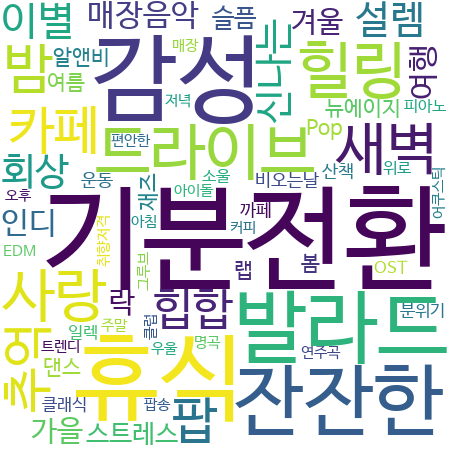

In [ ]:
# 태그 별 매핑 빈도 수 저장 
tag_cnt = plylst_tag_map.groupby('tags').tags.count().reset_index(name = 'mapping_cnt')
tag_cnt['tags'] = tag_cnt['tags'].astype(str)
tag_cnt['mapping_cnt'] = tag_cnt['mapping_cnt'].astype(int)

# 빈도 수가 1000회 이상인 태그만 저장
tag_cnt = tag_cnt[tag_cnt['mapping_cnt'] >= 1000]
word_count = list(zip(tag_cnt['tags'], tag_cnt['mapping_cnt']))

# plotting
wc = WordCloud(font_path = font_path, background_color = 'white', max_words = 100, width = 450, height = 450)
wc.generate_from_frequencies(dict(word_count)).to_image()

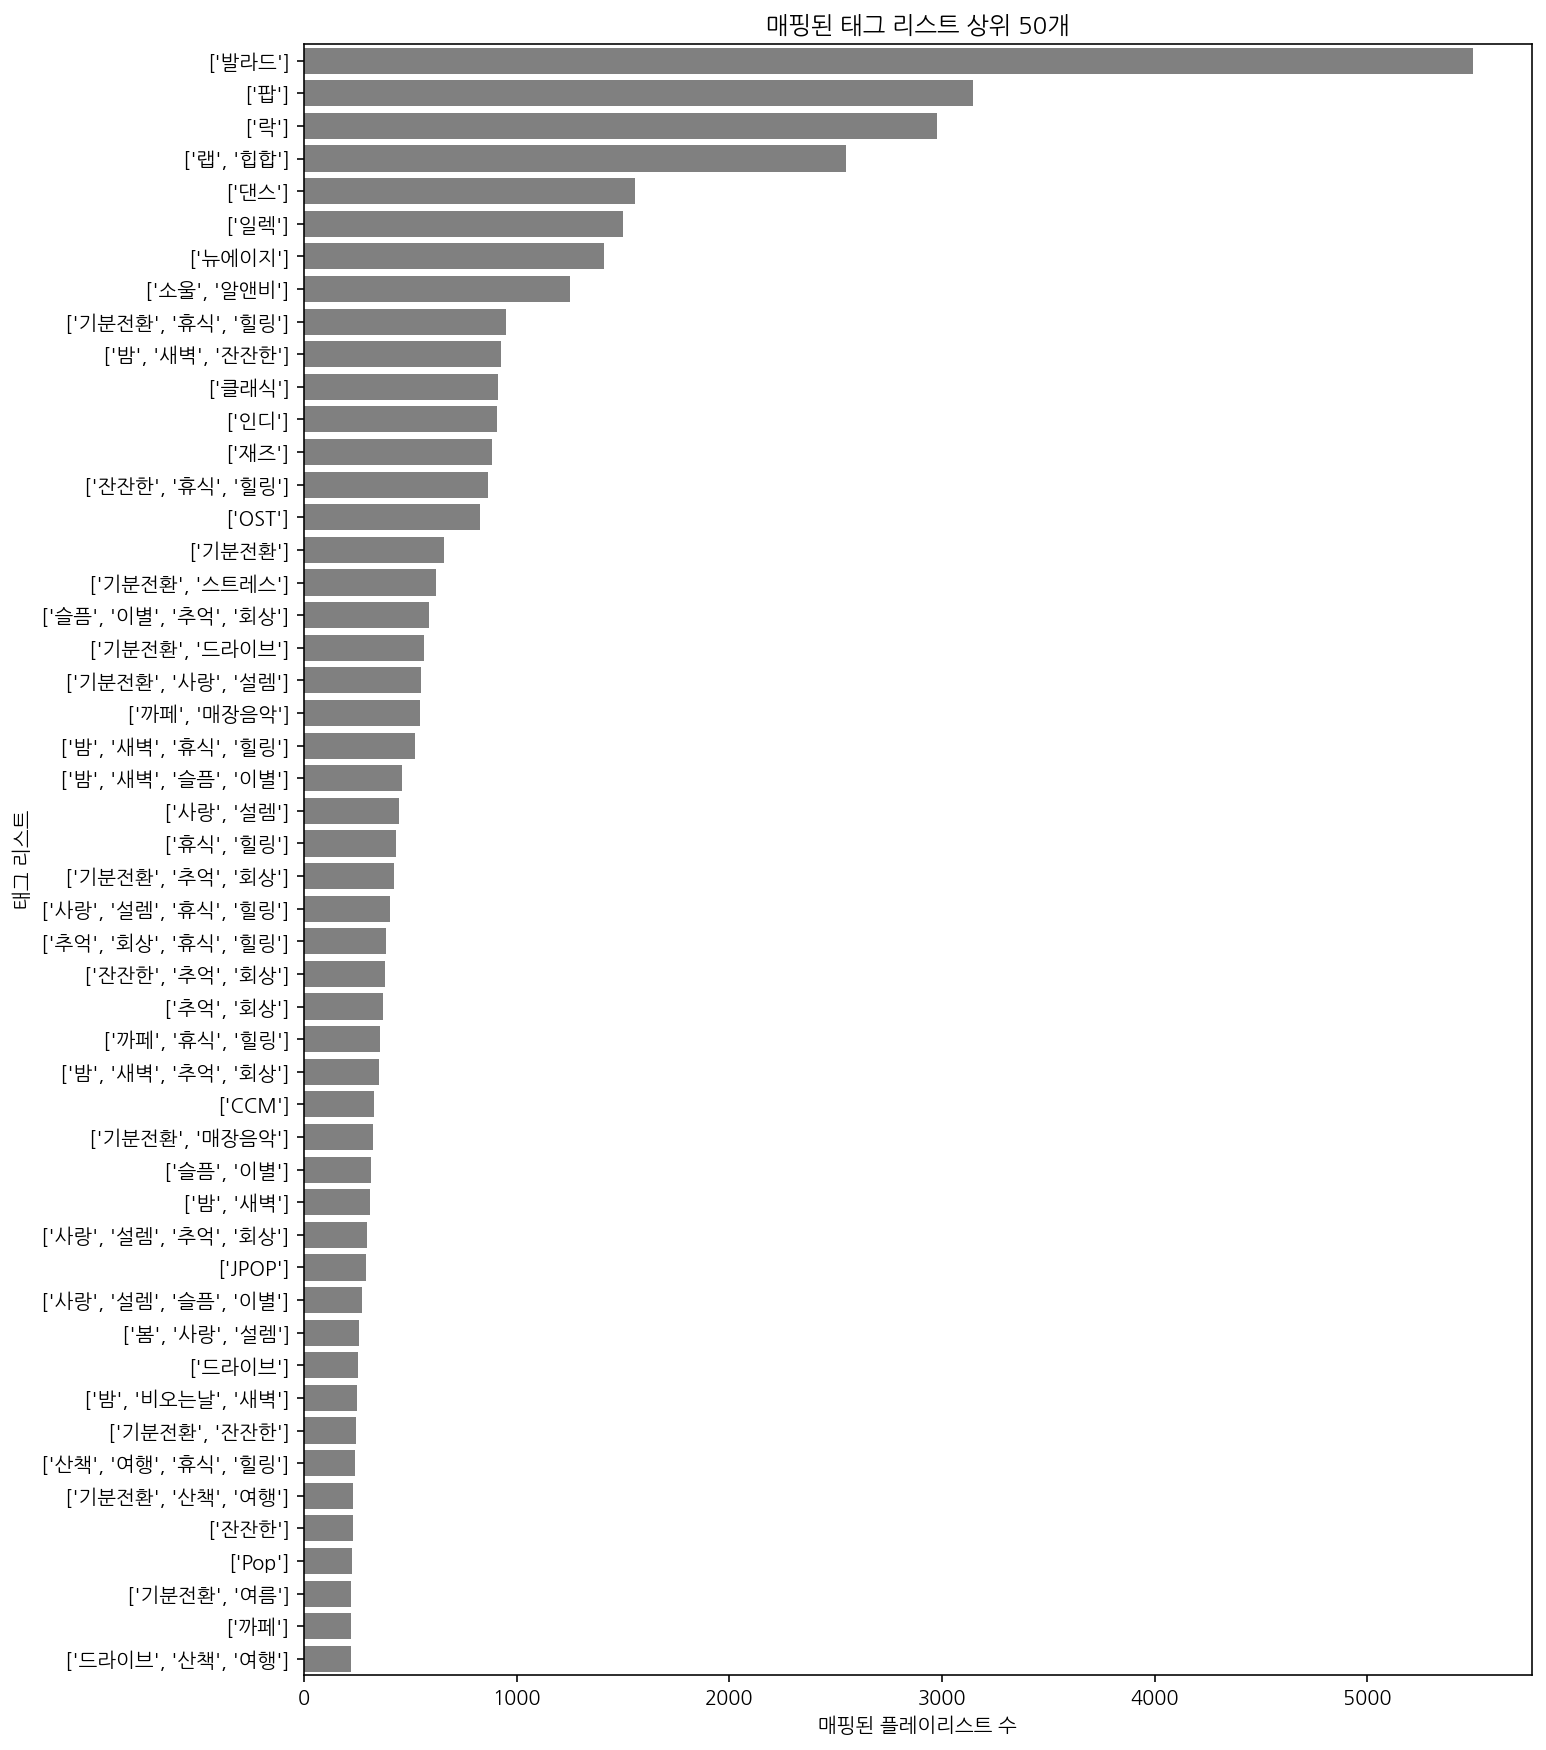

In [ ]:
# 1. unnest 데이터프레임인 plylst_tag_map 테이블에서 태그 이름 정렬 후 list로 묶기
plylst_tag_list_sort = plylst_tag_map.sort_values(by = ['id', 'tags']).groupby('id').tags.apply(list).reset_index(name = 'tag_list')

# 2. 집계를 위해 1번 테이블에서 list 타입을 문자열 타입으로 변경
plylst_tag_list_sort['tag_list'] = plylst_tag_list_sort['tag_list'].astype(str)

# 3. 태그 리스트 별 매핑되는 플레이리스트 수 집계 테이블 생성 : tag_list_plylst_cnt
tag_list_plylst_cnt = plylst_tag_list_sort.groupby('tag_list').id.nunique().reset_index(name = 'plylst_cnt')

# 4. 매핑 수 기준 상위 50개 필터링
tag_list_plylst_cnt = tag_list_plylst_cnt.nlargest(50, 'plylst_cnt')

# 5. plotting
plt.figure(figsize = (11, 15))
tag_list_plylst_cnt_plot = sns.barplot(y = 'tag_list', x = 'plylst_cnt', data = tag_list_plylst_cnt, color = 'grey')
tag_list_plylst_cnt_plot.set_title('매핑된 태그 리스트 상위 50개')
tag_list_plylst_cnt_plot.set_xlabel('매핑된 플레이리스트 수')
tag_list_plylst_cnt_plot.set_ylabel('태그 리스트')
plt.show()

In [ ]:
# 1. 플레이리스트-곡 테이블 plylst_song_map + 플레이리스트-태그 테이블 plylst_tag_map join 테이블 생성 : plylst_song_tag_map
plylst_song_tag_map = pd.merge(plylst_song_map, plylst_tag_map, how = 'left', on = 'id')

# 2. 1번 테이블 plylst_song_tag_map + 곡 장르 테이블 song_gnr_map join
plylst_song_tag_map = pd.merge(plylst_song_tag_map, song_gnr_map, how = 'left', left_on = 'songs', right_on = 'song_id')

# 3. 2번 테이블에서 장르 메타 join
gnr_code['gnr_code_name'] = gnr_code['gnr_code'] + ' (' + gnr_code['gnr_name'] + ')'
gnr_code = gnr_code[['gnr_code', 'gnr_code_name']]
plylst_song_tag_map = pd.merge(plylst_song_tag_map, gnr_code, how = 'left', on = 'gnr_code')

# 4. 최종 테이블 필드 선택
plylst_song_tag_map = plylst_song_tag_map[['id', 'songs', 'tags', 'gnr_code_name']]

In [ ]:
# 태그 = ['드라이브', '스트레스', '기분전환']
song_tag_map_sample_1 = plylst_song_tag_map.loc[plylst_song_tag_map.tags.isin(['드라이브', '스트레스', '기분전환']), :]
# 태그 = ['밤', '새벽', '잔잔한']
song_tag_map_sample_2 = plylst_song_tag_map.loc[plylst_song_tag_map.tags.isin(['밤', '새벽', '잔잔한']), :]
# 태그 = ['사랑', '설렘']
song_tag_map_sample_3 = plylst_song_tag_map.loc[plylst_song_tag_map.tags.isin(['사랑', '설렘']), :]
# 태그 = ['추억', '회상']
song_tag_map_sample_4 = plylst_song_tag_map.loc[plylst_song_tag_map.tags.isin(['추억', '회상']), :]
# 태그 = ['슬픔', '이별']
song_tag_map_sample_5 = plylst_song_tag_map.loc[plylst_song_tag_map.tags.isin(['슬픔', '이별']), :]
# 태그 = ['휴식', '힐링']
song_tag_map_sample_6 = plylst_song_tag_map.loc[plylst_song_tag_map.tags.isin(['휴식', '힐링']), :]
# 태그 = ['휴식', '힐링']
song_tag_map_sample_7 = plylst_song_tag_map.loc[plylst_song_tag_map.tags.isin(['카페', '매장음악']), :]

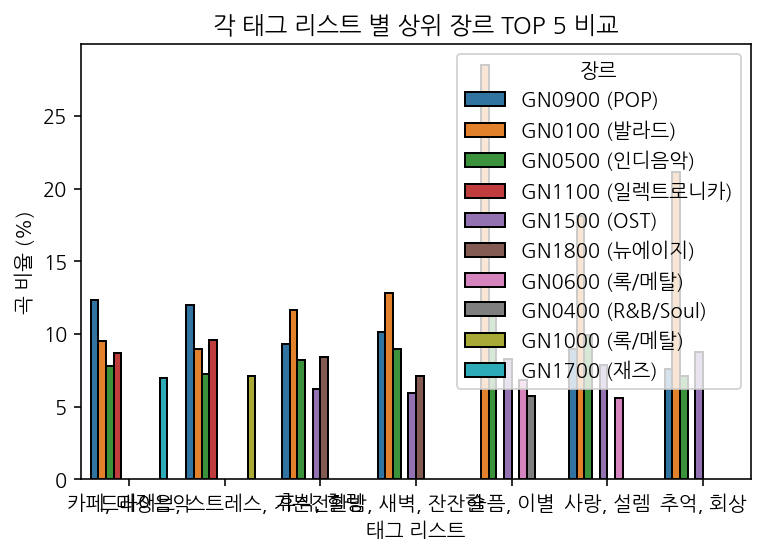

In [ ]:
# 각 샘플 태그 리스트 별 장르 비율 집계
song_tag_map_sample_1_gnr_rank = song_tag_map_sample_1.groupby('gnr_code_name').songs.nunique().reset_index(name = 'song_cnt')
song_tag_map_sample_1_gnr_rank.loc[:, 'song_cnt_ratio'] = round(song_tag_map_sample_1_gnr_rank['song_cnt']/sum(song_tag_map_sample_1_gnr_rank['song_cnt'])*100, 2)
song_tag_map_sample_1_gnr_rank['gnr_rank'] = song_tag_map_sample_1_gnr_rank['song_cnt_ratio'].rank(ascending = False)
song_tag_map_sample_1_gnr_rank['tag_list'] = '드라이브, 스트레스, 기분전환'
song_tag_map_sample_1_gnr_rank.rename(columns = {'gnr_code_name' : '장르', 'song_cnt' : '곡 수', 'song_cnt_ratio' : '비율(%)', 'gnr_rank' : '순위', 'tag_list' : '태그 리스트'}, inplace = True)

song_tag_map_sample_2_gnr_rank = song_tag_map_sample_2.groupby('gnr_code_name').songs.nunique().reset_index(name = 'song_cnt')
song_tag_map_sample_2_gnr_rank.loc[:, 'song_cnt_ratio'] = round(song_tag_map_sample_2_gnr_rank['song_cnt']/sum(song_tag_map_sample_2_gnr_rank['song_cnt'])*100, 2)
song_tag_map_sample_2_gnr_rank['gnr_rank'] = song_tag_map_sample_2_gnr_rank['song_cnt_ratio'].rank(ascending = False)
song_tag_map_sample_2_gnr_rank['tag_list'] = '밤, 새벽, 잔잔한'
song_tag_map_sample_2_gnr_rank.rename(columns = {'gnr_code_name' : '장르', 'song_cnt' : '곡 수', 'song_cnt_ratio' : '비율(%)', 'gnr_rank' : '순위', 'tag_list' : '태그 리스트'}, inplace = True)

song_tag_map_sample_3_gnr_rank = song_tag_map_sample_3.groupby('gnr_code_name').songs.nunique().reset_index(name = 'song_cnt')
song_tag_map_sample_3_gnr_rank.loc[:, 'song_cnt_ratio'] = round(song_tag_map_sample_3_gnr_rank['song_cnt']/sum(song_tag_map_sample_3_gnr_rank['song_cnt'])*100, 2)
song_tag_map_sample_3_gnr_rank['gnr_rank'] = song_tag_map_sample_3_gnr_rank['song_cnt_ratio'].rank(ascending = False)
song_tag_map_sample_3_gnr_rank['tag_list'] = '사랑, 설렘'
song_tag_map_sample_3_gnr_rank.rename(columns = {'gnr_code_name' : '장르', 'song_cnt' : '곡 수', 'song_cnt_ratio' : '비율(%)', 'gnr_rank' : '순위', 'tag_list' : '태그 리스트'}, inplace = True)

song_tag_map_sample_4_gnr_rank = song_tag_map_sample_4.groupby('gnr_code_name').songs.nunique().reset_index(name = 'song_cnt')
song_tag_map_sample_4_gnr_rank.loc[:, 'song_cnt_ratio'] = round(song_tag_map_sample_4_gnr_rank['song_cnt']/sum(song_tag_map_sample_4_gnr_rank['song_cnt'])*100, 2)
song_tag_map_sample_4_gnr_rank['gnr_rank'] = song_tag_map_sample_4_gnr_rank['song_cnt_ratio'].rank(ascending = False)
song_tag_map_sample_4_gnr_rank['tag_list'] = '추억, 회상'
song_tag_map_sample_4_gnr_rank.rename(columns = {'gnr_code_name' : '장르', 'song_cnt' : '곡 수', 'song_cnt_ratio' : '비율(%)', 'gnr_rank' : '순위', 'tag_list' : '태그 리스트'}, inplace = True)

song_tag_map_sample_5_gnr_rank = song_tag_map_sample_5.groupby('gnr_code_name').songs.nunique().reset_index(name = 'song_cnt')
song_tag_map_sample_5_gnr_rank.loc[:, 'song_cnt_ratio'] = round(song_tag_map_sample_5_gnr_rank['song_cnt']/sum(song_tag_map_sample_5_gnr_rank['song_cnt'])*100, 2)
song_tag_map_sample_5_gnr_rank['gnr_rank'] = song_tag_map_sample_5_gnr_rank['song_cnt_ratio'].rank(ascending = False)
song_tag_map_sample_5_gnr_rank['tag_list'] = '슬픔, 이별'
song_tag_map_sample_5_gnr_rank.rename(columns = {'gnr_code_name' : '장르', 'song_cnt' : '곡 수', 'song_cnt_ratio' : '비율(%)', 'gnr_rank' : '순위', 'tag_list' : '태그 리스트'}, inplace = True)

song_tag_map_sample_6_gnr_rank = song_tag_map_sample_6.groupby('gnr_code_name').songs.nunique().reset_index(name = 'song_cnt')
song_tag_map_sample_6_gnr_rank.loc[:, 'song_cnt_ratio'] = round(song_tag_map_sample_6_gnr_rank['song_cnt']/sum(song_tag_map_sample_6_gnr_rank['song_cnt'])*100, 2)
song_tag_map_sample_6_gnr_rank['gnr_rank'] = song_tag_map_sample_6_gnr_rank['song_cnt_ratio'].rank(ascending = False)
song_tag_map_sample_6_gnr_rank['tag_list'] = '휴식, 힐링'
song_tag_map_sample_6_gnr_rank.rename(columns = {'gnr_code_name' : '장르', 'song_cnt' : '곡 수', 'song_cnt_ratio' : '비율(%)', 'gnr_rank' : '순위', 'tag_list' : '태그 리스트'}, inplace = True)

song_tag_map_sample_7_gnr_rank = song_tag_map_sample_7.groupby('gnr_code_name').songs.nunique().reset_index(name = 'song_cnt')
song_tag_map_sample_7_gnr_rank.loc[:, 'song_cnt_ratio'] = round(song_tag_map_sample_7_gnr_rank['song_cnt']/sum(song_tag_map_sample_7_gnr_rank['song_cnt'])*100, 2)
song_tag_map_sample_7_gnr_rank['gnr_rank'] = song_tag_map_sample_7_gnr_rank['song_cnt_ratio'].rank(ascending = False)
song_tag_map_sample_7_gnr_rank['tag_list'] = '카페, 매장음악'
song_tag_map_sample_7_gnr_rank.rename(columns = {'gnr_code_name' : '장르', 'song_cnt' : '곡 수', 'song_cnt_ratio' : '비율(%)', 'gnr_rank' : '순위', 'tag_list' : '태그 리스트'}, inplace = True)

# delete object
del song_tag_map_sample_1, song_tag_map_sample_2, song_tag_map_sample_3, song_tag_map_sample_4, song_tag_map_sample_5, song_tag_map_sample_6, song_tag_map_sample_7

# row binding
song_tag_map_sample_rbind = pd.concat(
    [song_tag_map_sample_1_gnr_rank, song_tag_map_sample_2_gnr_rank, song_tag_map_sample_3_gnr_rank,
     song_tag_map_sample_4_gnr_rank, song_tag_map_sample_5_gnr_rank, song_tag_map_sample_6_gnr_rank,
     song_tag_map_sample_7_gnr_rank],
    axis = 0
)

# plotting
song_tag_map_sample_rbind_plot = sns.barplot(
    data = song_tag_map_sample_rbind.loc[song_tag_map_sample_rbind['순위'] <= 5, :].sort_values(by = '순위'),
    x = '태그 리스트', y = '비율(%)', hue = '장르', edgecolor = "black"
)
song_tag_map_sample_rbind_plot.set_title('각 태그 리스트 별 상위 장르 TOP 5 비교')
song_tag_map_sample_rbind_plot.set_xlabel('태그 리스트')
song_tag_map_sample_rbind_plot.set_ylabel('곡 비율 (%)')
plt.show()

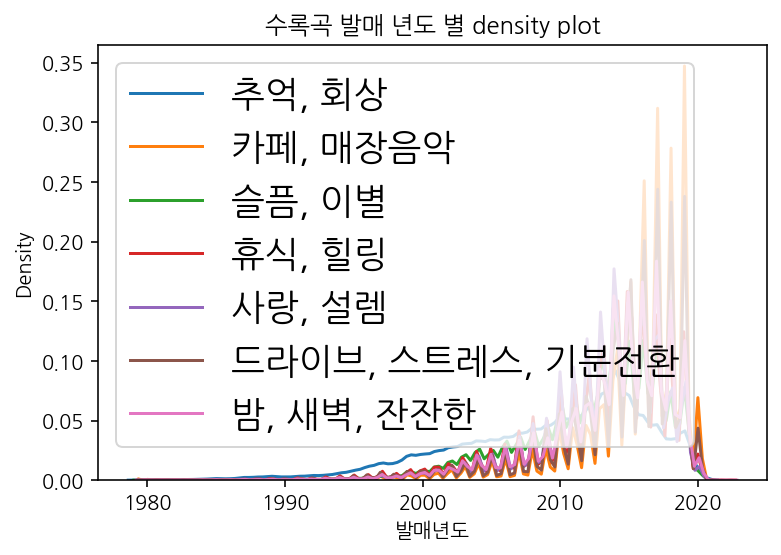

In [ ]:
# 위에서 생성한 테이블에서 곡 별 발매년도 join
plylst_song_tag_map_issue_year = pd.merge(plylst_song_tag_map, song_issue_date, how = 'left', left_on = 'songs', right_on = 'song_id')

# 샘플 태그들이 포함되어 있는 플레이리스트만 필터링
plylst_song_tag_map_issue_year_filter = plylst_song_tag_map_issue_year.loc[plylst_song_tag_map_issue_year.tags.isin(['드라이브', '스트레스', '기분전환', '밤', '새벽', '잔잔한', '사랑', '설렘', '추억', '회상', '슬픔', '이별', '휴식', '힐링', '카페', '매장음악']), :]
plylst_song_tag_map_issue_year_filter['issue_year'] = plylst_song_tag_map_issue_year_filter['issue_year'].apply(pd.to_numeric)
plylst_song_tag_map_issue_year_filter = plylst_song_tag_map_issue_year_filter[plylst_song_tag_map_issue_year_filter['issue_year'] >= 1980]

del plylst_song_tag_map_issue_year

# plotting
temp_df = plylst_song_tag_map_issue_year_filter.loc[plylst_song_tag_map_issue_year_filter.tags.isin(['추억', '회상']), :]
sns.distplot(temp_df['issue_year'], hist = False, kde = True, label = '추억, 회상')
temp_df = plylst_song_tag_map_issue_year_filter.loc[plylst_song_tag_map_issue_year_filter.tags.isin(['카페', '매장음악']), :]
sns.distplot(temp_df['issue_year'], hist = False, kde = True, label = '카페, 매장음악')
temp_df = plylst_song_tag_map_issue_year_filter.loc[plylst_song_tag_map_issue_year_filter.tags.isin(['슬픔', '이별']), :]
sns.distplot(temp_df['issue_year'], hist = False, kde = True, label = '슬픔, 이별')
temp_df = plylst_song_tag_map_issue_year_filter.loc[plylst_song_tag_map_issue_year_filter.tags.isin(['휴식', '힐링']), :]
sns.distplot(temp_df['issue_year'], hist = False, kde = True, label = '휴식, 힐링')
temp_df = plylst_song_tag_map_issue_year_filter.loc[plylst_song_tag_map_issue_year_filter.tags.isin(['사랑', '설렘']), :]
sns.distplot(temp_df['issue_year'], hist = False, kde = True, label = '사랑, 설렘')
temp_df = plylst_song_tag_map_issue_year_filter.loc[plylst_song_tag_map_issue_year_filter.tags.isin(['드라이브', '스트레스', '기분전환']), :]
sns.distplot(temp_df['issue_year'], hist = False, kde = True, label = '드라이브, 스트레스, 기분전환')
temp_df = plylst_song_tag_map_issue_year_filter.loc[plylst_song_tag_map_issue_year_filter.tags.isin(['밤', '새벽', '잔잔한']), :]
sns.distplot(temp_df['issue_year'], hist = False, kde = True, label = '밤, 새벽, 잔잔한')
plt.legend(prop = {'size' : 18})
plt.title('수록곡 발매 년도 별 density plot')
plt.xlabel('발매년도')
plt.ylabel('Density')
plt.show()

In [ ]:
# 학습 데이터 내에서 가장 많은 태그가 매핑된 아이유 - 밤편지 (144663) 예시
example_song = plylst_song_tag_map[plylst_song_tag_map['songs'] == '144663']
example_song

,id,songs,tags,gnr_code_name
36032,7984,144663,슬픔,GN0100 (발라드)
36033,7984,144663,거짓말,GN0100 (발라드)
36034,7984,144663,이별,GN0100 (발라드)
36035,7984,144663,아픈,GN0100 (발라드)
115027,106802,144663,힐링,GN0100 (발라드)
...,...,...,...,...
29580419,13178,144663,새벽,GN0100 (발라드)
29580420,13178,144663,새벽아침,GN0100 (발라드)
29580421,13178,144663,활기찬,GN0100 (발라드)
29580422,13178,144663,산책,GN0100 (발라드)


In [ ]:
# 곡 별 매핑되는 태그 수 집계 : song_tag_map_cnt
song_tag_map_cnt = plylst_song_tag_map.groupby('songs').tags.nunique().reset_index(name = 'tags_cnt')
round(song_tag_map_cnt.describe().loc[['min', '25%', '50%', 'mean', '75%', 'max', 'std']].transpose(), 2)

,min,25%,50%,mean,75%,max,std
tags_cnt,1.0,2.0,7.0,17.86,15.0,1928.0,44.95


In [ ]:
example_song.groupby(['songs', 'tags']).id.nunique().reset_index(name = 'mapping_plylst_cnt').sort_values(by = 'mapping_plylst_cnt', ascending = False)

,songs,tags,mapping_plylst_cnt
241,144663,감성,690
770,144663,발라드,543
1462,144663,잔잔한,413
1699,144663,카페,395
940,144663,새벽,339
...,...,...,...
782,144663,밤공기,1
781,144663,밤감성,1
779,144663,발랄한노래,1
778,144663,발라드핫트랙,1


In [ ]:
example_temp = plylst_song_tag_map.loc[plylst_song_tag_map['tags'] == '감성', :].groupby('songs').id.nunique().reset_index(name = 'mapping_plylst_cnt').sort_values(by = 'mapping_plylst_cnt', ascending = False)
pd.merge(example_temp, song_meta[['id', 'song_name', 'artist_name_basket']], how = 'left', left_on = 'songs', right_on = 'id').head(10)

,songs,mapping_plylst_cnt,id,song_name,artist_name_basket
0,357367,735,357367,비,[폴킴]
1,144663,690,144663,밤편지,[아이유]
2,519391,678,519391,Love Again,[김제훈]
3,640657,667,640657,내가 말하고 싶은건,[김제훈]
4,463173,662,463173,비가 내렸어 (Vocal by 스티브언니),[업라이트 (Upright)]
5,349492,659,349492,어떤이별,[임승부]
6,427724,653,427724,지워줄게 (Vocal by 스티브언니),[아재]
7,680366,650,680366,끝내지 못한 이야기 (Feat. 호수),[어쿠스틱 멜로디 (Acoustic Melody)]
8,520093,641,520093,고마운 사람 (Vocal by 이소진),[업라이트 (Upright)]
9,215411,639,215411,지금보다 조금 (Feat. 이원),[어쿠스틱 멜로디 (Acoustic Melody)]
